TP 3 - Ejercicio 2 - Grupo 3: Guadalupe Sosa Ferro y Florencia Denisse Costa

# Install, importar librerías y montar Drive

In [ ]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from sklearn import svm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Cargar imágenes

Para cargar las imágenes utilizamos la función `cv2.imread` coloacando como parámetro el *path* de la imagen y al parámetro *flag* le pusimos un 1 indicando su lectura en color.

In [ ]:
imagen = cv2.imread('/content/cow.jpg',1) #con 1 la leemos a color
imagen_RGB = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)#pasamos la imagen de BGR a RGB
print(imagen_RGB.shape)

(760, 1140, 3)


In [ ]:
print(imagen_RGB[2])

[[ 98 135 151]
 [100 137 153]
 [ 98 135 151]
 ...
 [148 168 175]
 [146 166 173]
 [144 164 171]]


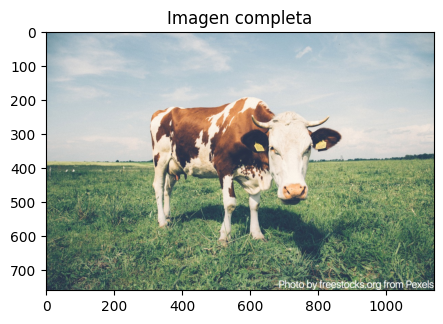

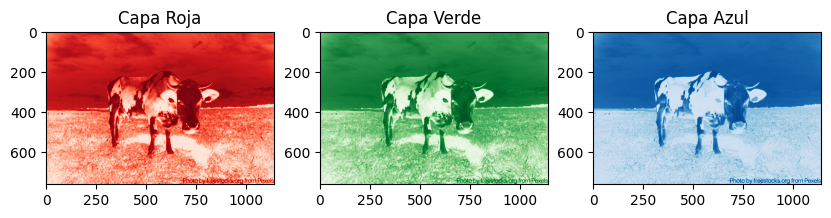

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(imagen_RGB)
plt.title('Imagen completa')
plt.show()

plt.figure(figsize=(10,25))
plt.subplot(131),plt.imshow(imagen_RGB[:,:,0], cmap="Reds"), plt.title('Capa Roja')
plt.subplot(132),plt.imshow(imagen_RGB[:,:,1], cmap="Greens"), plt.title('Capa Verde')
plt.subplot(133),plt.imshow(imagen_RGB[:,:,2], cmap="Blues"), plt.title('Capa Azul')
plt.show()

En una primera instancia intentamos visualizar la imagen de la vaca completa separándola en las capas R, G, B para ver si en una de ellas había un mayor contraste entre el pasto, la vaca y el cielo. Sin embargo, no vimos una mejora y por ello decidimos continuar el procedimiento utilizando las tres capas juntas.

Luego, visualizamos las tres porciones correspondientes a la vaca, el pasto y el cielo.

In [ ]:
cielo = cv2.imread('/content/cielo.jpg',1)
cielo_RGB = cv2.cvtColor(cielo, cv2.COLOR_BGR2RGB)
pasto = cv2.imread('/content/pasto.jpg',1)
pasto_RGB = cv2.cvtColor(pasto, cv2.COLOR_BGR2RGB)
vaca = cv2.imread('/content/vaca.jpg',1)
vaca_RGB = cv2.cvtColor(vaca, cv2.COLOR_BGR2RGB)

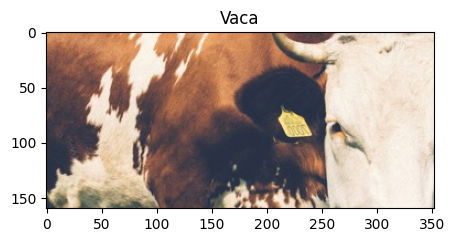

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(vaca_RGB)
plt.title('Vaca')
plt.show()

In [ ]:
print(vaca_RGB.shape) #tamaño de la porción de imagen de la vaca

(160, 352, 3)


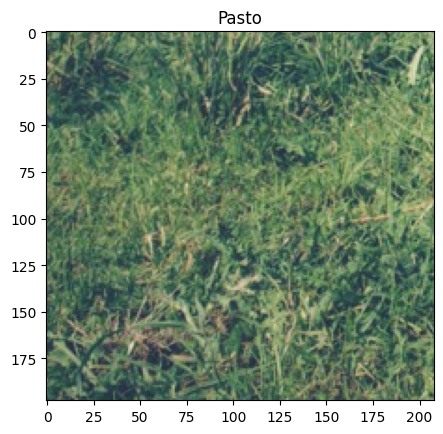

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(pasto_RGB)
plt.title('Pasto')
plt.show()

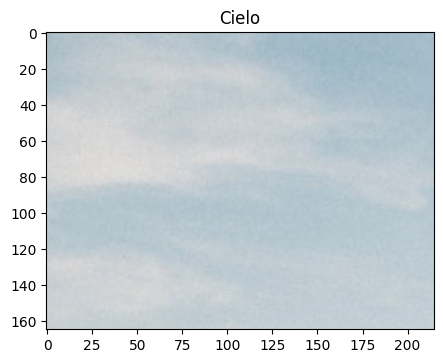

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(cielo_RGB)
plt.title('Cielo')
plt.show()

# a) Crear conjunto de datos

Para construir el conjunto de datos de entrenamiento, se guardaron las imágenes de muestra en una matriz bidimensional. Para ello se aplicó la función```agregarColumna```. Esta toma una matriz tridimensional (matriz) y un valor escalar (k) como entrada y devuelve una nueva matriz 2D que es el resultado de agregar una columna a matriz con todos los elementos iguales a k. 

En la nueva columna se guardará la etiqueta correspondiente:
* Vaca = 0
* Pasto = 1
* Cielo = 2

Cabe aclarar que los píxeles de la matriz se apilan en una sola dimensión y el número de canales se mantiene igual.



In [ ]:
def agregarColumna(matriz, k):
  altura, ancho, canales = matriz.shape
  matriz_2d = np.reshape(matriz, (altura * ancho, canales))
  nueva_mat = np.hstack((matriz_2d, np.full((matriz_2d.shape[0], 1), k)))
  return nueva_mat

In [ ]:
# Vaca clase 0, pasto clase 1, cielo clase 2
vaca_mat = agregarColumna(vaca_RGB, 0)
print(vaca_mat.shape)
pasto_mat = agregarColumna(pasto_RGB, 1)
print(pasto_mat.shape)
cielo_mat = agregarColumna(cielo_RGB, 2)
print(cielo_mat.shape)

(56320, 4)
(41184, 4)
(35475, 4)


Luego concatenamos las tres matrices etiquetadas para formar el conjunto de datos.

In [ ]:
datos = np.concatenate((vaca_mat, pasto_mat, cielo_mat), axis=0)

In [ ]:
print(np.shape(datos))

(132979, 4)


Podemos ver que el 42.4% de los datos corresponden a píxeles de vaca, el 30.9% a pasto y el 26.7% al cielo. La diferencia entre ambos no es grande por eso podemos decir que los datos están bastante balanceados.

# b) Dividir en conjunto de entrenamiento y prueba

Pasamos los datos a un dataframe y los mezclamos. Luego dividimos los datos en testeo (20%) y entrenamiento (80%).

In [ ]:
df_datos = pd.DataFrame(datos, columns=["R", "G", "B", "Clase"])

In [ ]:
datos_1 = df_datos.sample(frac = 1, random_state=1).reset_index(drop = True) # Mezclar los datos
test_size = 0.2 # Fracción del tamaño del conjunto de prueba
l = int(test_size*len(datos_1))
datos_test = datos_1[:l].reset_index(drop = True)
datos_train = datos_1[l:].reset_index(drop = True)
print(np.shape(datos_test))
print(np.shape(datos_train))

(26595, 4)
(106384, 4)


Guardamos por separado las clases correspondiente al grupo de testeo y de entrenamiento respecto a los valores de R,G,B de cada elemento.

In [ ]:
x_train = datos_train.iloc[:, :3]
y_train = datos_train["Clase"]
x_test = datos_test.iloc[:, :3]
y_test = datos_test["Clase"]

# c) SVM

SVM es el acrónimo de Support Vector Machine, que en español se traduce como Máquina de Vectores de Soporte. SVM es un algoritmo de aprendizaje automático supervisado que se utiliza para la clasificación y regresión de datos.

La idea principal detrás de SVM es encontrar un hiperplano óptimo que separe los puntos de datos de diferentes clases en un espacio de características de alta dimensión. El objetivo es encontrar un hiperplano de separación que maximice la distancia entre las muestras de entrenamiento más cercanas de diferentes clases, también conocidas como vectores de soporte.

Cuando el conjunto de datos no es linealmente separable utiliza una técnica llamada "kernel trick" o truco del kernel. Los kernels permiten transformar los datos de entrada a un espacio de características de mayor dimensión, donde los datos pueden ser más fácilmente separables. Los tipos comunes de kernels utilizados en SVM son el kernel lineal, polinomial y radial.



## Calcular modelo

Las diferencias entre estos kernels se encuentra en la forma en que transforman los datos de entrada para facilitar la separación de las clases en un espacio de características de mayor dimensión.

* Kernel Lineal: no realiza ninguna transformación no lineal de los datos de entrada. Simplemente calcula el producto escalar entre los vectores de características originales.

* Kernel radial: aplica una transformación no lineal a los datos de entrada utilizando una función de base radial. El kernel RBF asigna un peso a cada muestra de entrenamiento basado en la distancia radial entre la muestra y un centro determinado.

* Kernel polinómico: aplica una transformación polinómica a los datos de entrada. Permite modelar relaciones no lineales de mayor grado entre las características originales. El grado del polinomio se puede ajustar como parámetro. 

Calculamos los distintos modelos usando la librería sklearn, variando los kernels. Para el caso lineal utilizamos la función svm.LinearSVC ya que es recomendado para conjuntos de datos grandes.

Cabe destacar que este algoritmo es un clasificador binario, pero que la librería Sklearn emplea el método de uno contra uno para poder clasificar más de dos clases (en este caso en particular 3 clases: vaca, cielo, pasto).


In [ ]:
def calcularModelo(x_train, y_train, x_test, tipo, c):
  if tipo == "lineal":
    clf = svm.LinearSVC(C = c, max_iter = 5000)
  else:
    clf = svm.SVC(C = c, kernel = tipo)
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)

  return y_pred, clf

Intentamos ajustar los parámetros C y gamma de los modelos para ver cómo afectaban a la clasifición.

El parámetro `C` es un hiperparámetro que se utiliza para ajustar el modelo de una máquina de vectores de soporte (SVM, por sus siglas en inglés) en Scikit-Learn. El hiperparámetro `C` controla el equilibrio entre la clasificación correcta de los puntos de datos de entrenamiento y la maximización del margen de separación entre las clases. Controla la cantidad de violación de los límites de decisión. Un valor de `C` alto permitirá una menor violación de los límites de decisión y una mayor precisión en la clasificación de los datos de entrenamiento, mientras que un valor de `C` bajo permitirá una mayor violación de los límites de decisión y un margen de separación más grande. En términos generales, un valor alto de `C` puede resultar en un modelo más complejo y con mayor riesgo de sobreajuste, mientras que un valor bajo de `C` puede resultar en un modelo más simple pero con un margen de separación más grande y un mayor riesgo de subajuste. En resumen, el parámetro `C` en Scikit-Learn es un hiperparámetro que se utiliza para ajustar el equilibrio entre la precisión en la clasificación de los datos de entrenamiento y la maximización del margen de separación entre las clases.

El parámetro gamma (solo para los kernels polinómico y radial) controla la influencia de un solo ejemplo de entrenamiento en el cálculo de la frontera de decisión. Valores más altos de gamma hacen que el modelo considere ejemplos de entrenamiento más cercanos. 

Para el kernel "rbf" (radial basis function), que es el kernel predeterminado en SVC, los valores típicos de gamma suelen estar en el rango [0.1, 10].

El valor de "gamma" en el kernel polinómico generalmente se encuentra en el rango (0, 1]. Valores más cercanos a cero resultan en un término binomial con menos influencia y pueden generar fronteras de decisión más suaves. Por otro lado, valores cercanos a uno aumentan la influencia del término binomial, lo que puede generar fronteras de decisión más ajustadas y complejas.

Sin embargo al intentar realizar la clasificación, no pudimos probar modificando el gamma ya que las simulacioens tardaban más de 30 minutos sin obtener resultado alguno.

## Métricas

Para el cálculo de las métricas empleamos las funciones ya utilizadas en los anteriores trabajos prácticos.

### Matriz de confusión del modelo

In [ ]:
def calcularMatrizConfusion(array_pred, array_real, tipo, c):

  metricas_categorias = { 
        '0': {'00': 0, '01': 0, '02': 0},
        '1': {'10': 0, '11': 0, '12': 0},
        '2': {'20': 0, '21': 0, '22': 0},
    } 

  for i in range(len(array_pred)):
    # Obtiene el codigo --> la posición en la matriz
    codigo =  str(array_real[i]) + str(array_pred[i])
    metricas_categorias[str(array_real[i])][codigo] += 1
  
  matriz_confusion = np.zeros((3,3))

  for i in range(3):
    for j in range(3):
      codigo = str(i) + str(j)
      matriz_confusion[i-1, j-1] = metricas_categorias[str(i)][codigo]

  matriz_confusion_n = np.round(matriz_confusion.astype('float') / (matriz_confusion.sum(axis=1)[:, np.newaxis]), decimals = 3)

  plt.figure()
  # Graficar matriz como heatmap para que quede con los colores 
  sns.heatmap(matriz_confusion_n, annot=True, fmt='g', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'], cmap="crest")
  plt.title(f"Matriz de confusión SVM {tipo} con C = {c}")
  plt.xlabel("Predicciones")
  plt.ylabel("Verdaderas")
  plt.show()

  return

### Matrices de confusión por categoría

In [ ]:
def matrices_confusion(array_pred, array_real, tipo, c):

  categorias = ["0","1","2"]
  categorias_nombre = ["vaca", "pasto", "cielo"]

  categorias_datos = array_real 
  clasificacion_datos = array_pred

  # Se crea un diccionario de diccionarios, donde cada clave es una categoria y su valor es un diccionario,
  # que contiene las cantidades de VP, VN, FP, FN y total
  # total es la cantidad de pixels que realmente corresponden a dicha categoria.
  P_N_categorias = {
        '0': {'VP': 0, 'VN': 0, 'FP': 0, 'FN': 0, 'total': 0}, 
        '1': {'VP': 0, 'VN': 0, 'FP': 0, 'FN': 0, 'total': 0},
        '2': {'VP': 0, 'VN': 0, 'FP': 0, 'FN': 0, 'total': 0},
    }

  for categoria in categorias: # Para cada categoria de las analizadas

    # Calcular VP --> clasificacion (predicho) == categoria (real) 
    VP = 0
    for i in range(len(categorias_datos)):
      if ((int(categoria) == categorias_datos[i]) and (clasificacion_datos[i] == categorias_datos[i])):
        # El dato se guarda si se cumple que es VP y ademas si la categoria que se está analizando es igual a la del pixel
        VP += 1
    diccionario_categoria = P_N_categorias[categoria] 
    diccionario_categoria["VP"] = VP # Se guarda en el diccionario de la categoria la cantidad de VP contados en el DF de entrenamiento

    # Calcular FP --> aquellos pixels que fueron clasificados en la categoria analizada pero en realidad no pertenecen a ella 
    FP = 0
    for i in range(len(categorias_datos)):
      if  ((clasificacion_datos[i] == int(categoria)) and (categorias_datos[i] != int(categoria))):
        # Se suma uno a la cantidad de FP si la clasificacion del pixel es igual a la categoria analizada
        # y si la categoria real del pixel es distinta a la categoria analizada
        FP += 1
    diccionario_categoria = P_N_categorias[categoria]
    diccionario_categoria["FP"] = FP

    # Calcular VN --> aquellos pixels cuya categoria real es distinta a la analizada y que fueron clasificados con la categoria distinta a la analizada (ya sea correctamente o no)
    VN = 0
    for i in range(len(categorias_datos)):
      if (((int(categoria) != categorias_datos[i]) and (clasificacion_datos[i] != categorias_datos[i]) and (int(categoria) != clasificacion_datos[i])) or ((int(categoria) != clasificacion_datos[i]) and (clasificacion_datos[i] == categorias_datos[i]))):
        # Se suma uno si la categoria analizada es distinta a la categoria real del pixel y si la clasificacion es distinta a la categoria real
        # y si además la categoria analizada es distinta a la clasificacion del pixel.
        # O puede ocurrir que la categoria analizada sea distinta a la categoria real del pixel y se clasificó correctamente
        VN += 1
    diccionario_categoria = P_N_categorias[categoria]
    diccionario_categoria["VN"] = VN

    # Calcular FN --> aquellos pixels cuya categoria real es igual a la analizada pero fueron incorrectamente clasificados
    FN = 0
    for i in range(len(categorias_datos)):
      if (categorias_datos[i] == int(categoria)) and (clasificacion_datos[i] != categorias_datos[i]):
        # Se suma uno si la categoria real del pixel es igual a la analizada y si la clasificacion es distinta a la categoria real
        FN += 1
    diccionario_categoria = P_N_categorias[categoria]
    diccionario_categoria["FN"] = FN

    # Calcular total --> se suman todos los titulares cuya categoria real es igual a la analizada
    total = 0 
    for i in range(len(categorias_datos)):
      if (categorias_datos[i] == int(categoria)): 
        total += 1
    diccionario_categoria = P_N_categorias[categoria]
    diccionario_categoria["total"] = total
  
  # Matrices de confusion por categoria

  matriz_confusion = np.zeros((2, 2)) # Matriz de 2x2 con ceros

  for i in range(len(categorias)): # Para cada categoria se guardan los datos correspondientes para obtener una matriz de confusión
    matriz_confusion[0, 0] = P_N_categorias[categorias[i]]['VP']
    matriz_confusion[0, 1] = P_N_categorias[categorias[i]]['FN']
    matriz_confusion[1, 0] = P_N_categorias[categorias[i]]['FP']
    matriz_confusion[1, 1] = P_N_categorias[categorias[i]]['VN']

    # Normalizacion de la matriz de confusion
    matriz_confusion_n = np.round(matriz_confusion.astype('float') / matriz_confusion.sum(axis=1)[:, np.newaxis], decimals=3)

    plt.figure()
    # Graficar matriz como heatmap para que quede con los colores 
    sns.heatmap(matriz_confusion_n, annot=True, fmt='g', xticklabels=['P', 'N'], yticklabels=['P', 'N'], cmap="crest")
    plt.title(f"Matriz de confusión: {str(categorias_nombre[i])} SVM {tipo} con C = {c}")
    plt.xlabel("Predicciones")
    plt.ylabel("Verdaderas")
    plt.show()
  
  return P_N_categorias

### Precisión por categoría

In [ ]:
def metricas(dict_V_o_F, tipo, c):
   
  # Diccionario donde cada categoria tiene un diccionario con sus metricas
  metricas_categorias = {
        '0': {'accuracy': 0, 'precision': 0, 'F1_score': 0, 'TVP': 0, 'TFP': 0},
        '1': {'accuracy': 0, 'precision': 0, 'F1_score': 0, 'TVP': 0, 'TFP': 0},
        '2': {'accuracy': 0, 'precision': 0, 'F1_score': 0, 'TVP': 0, 'TFP': 0},
    }

  # Utiliza como datos el diccionario previamente obtenido con los VP, FP, VN, FN
  for categoria in range(3): 
    VP = dict_V_o_F[str(categoria)]['VP']
    FN = dict_V_o_F[str(categoria)]['FN']
    FP = dict_V_o_F[str(categoria)]['FP']
    VN = dict_V_o_F[str(categoria)]['VN']

    # Calcular accuracy
    accuracy = (VP+VN)/(VP+VN+FN+FP)
    metricas_categorias[str(categoria)]['accuracy'] = accuracy

    # Calcular precision
    if VP == 0:
      precision = 0
    else:
      precision = VP/(VP+FP)
    metricas_categorias[str(categoria)]['precision'] = precision

    # Calcular TVP
    if VP == 0:
      TVP = 0
    else:
      TVP = VP/(VP+FN)
    metricas_categorias[str(categoria)]['TVP'] = TVP

    # Calcular F1-score
    if precision != 0 and TVP != 0:
      F1_score = (2*precision*TVP)/(precision+TVP)
    else:
      F1_score = 0
    metricas_categorias[str(categoria)]['F1_score'] = F1_score

    # Calcular TFP
    if FP == 0:
      TFP = 0
    else:
      TFP = FP/(FP+VN)
    metricas_categorias[str(categoria)]['TFP'] = TFP

  # Graficos

  # Convertimos el diccionario a un dataframe para realizar el grafico de barras multiples
  df_metricas_categorias = pd.DataFrame([key for key in metricas_categorias.keys()], columns=['Categorías'])
  #df_metricas_categorias['Accuracy'] = [value['accuracy'] for value in metricas_categorias.values()]
  df_metricas_categorias['Precisión'] = [value['precision'] for value in metricas_categorias.values()]
  #df_metricas_categorias['TVP'] = [value['TVP'] for value in metricas_categorias.values()]
  #df_metricas_categorias['F1_score'] = [value['F1_score'] for value in metricas_categorias.values()]
  #df_metricas_categorias['TFP'] = [value['TFP'] for value in metricas_categorias.values()]
  # Grafico realizado con función de Pandas (utiliza el DF)
  #["Accuracy","Precision","TVP","F1_score","TFP"]
  ax = df_metricas_categorias.plot(x="Categorías", y="Precisión", kind="bar", figsize=(4,4),
                                   title=f"Precisión SVM {tipo} con C = {c}", ylim=(0, 1.1)) 
  ax.legend().remove()
  plt.show()

  return metricas_categorias

### Precisión del modelo

In [ ]:
def precisionClasificador(P_N_categorias):
  VP_total = 0
  VN_total = 0
  FP_total = 0
  FN_total = 0

  for clase in P_N_categorias:
    for metrica in P_N_categorias[clase]:
      if metrica == 'VP':
        VP_total += P_N_categorias[clase][metrica]
      elif metrica == 'VN':
        VN_total += P_N_categorias[clase][metrica]
      elif metrica == 'FP':
        FP_total += P_N_categorias[clase][metrica]
      elif metrica == 'FN':
        FN_total += P_N_categorias[clase][metrica]
  
  #accuracy = (VP_total + VN_total) / (VP_total + VN_total + FP_total + FN_total)
  precision = VP_total / (VP_total + FP_total)
  #recall = VP_total / (VP_total + FN_total)
  #metricas = [accuracy, precision, recall]

  return precision

## Diferentes núcleos y valores de C

La función ```clasificarPixeles``` calcula los distintos modelos (con los diferentes kernels) y llama a las funciones para calcular las métricas para su correspondiente evalución.



In [ ]:
def clasificarPixels(x_train, y_train, x_test, y_test, c, tipo):
  # Calcular modelo
  y_pred, clf = calcularModelo(x_train, y_train, x_test, tipo, c)

  # Calcular matriz de confusión
  calcularMatrizConfusion(y_pred, np.array(y_test), tipo, c)

  # Calcular matrices de confusión
  P_N_categorias = matrices_confusion(y_pred, np.array(y_test), tipo, c)

  # Calcular precisión por categoría
  metricas_categorias = metricas(P_N_categorias, tipo, c)

  # Calcular precisión del modelo
  precision_modelo = precisionClasificador(P_N_categorias)
  print(f"La precisión del clasificador SVM {tipo} con C = {c} es: {round(precision_modelo, 3)}")

  return

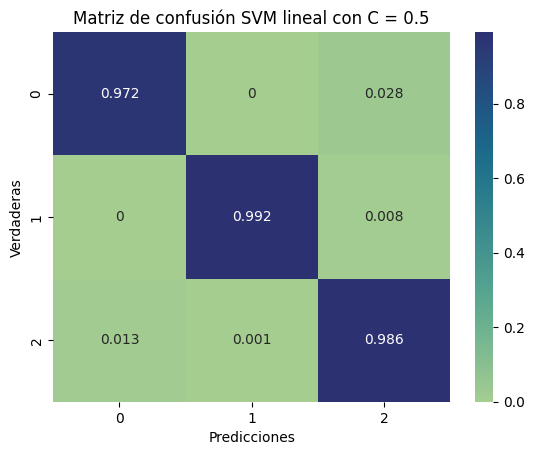

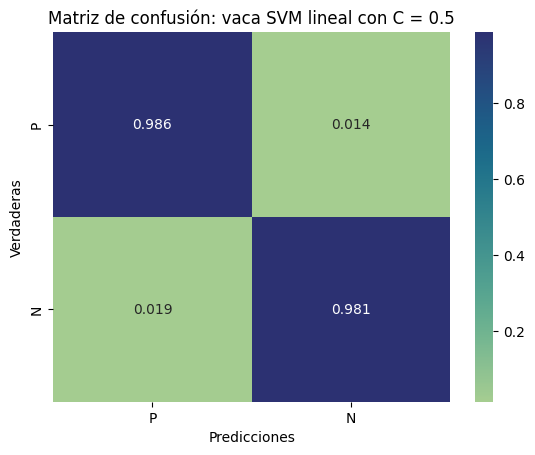

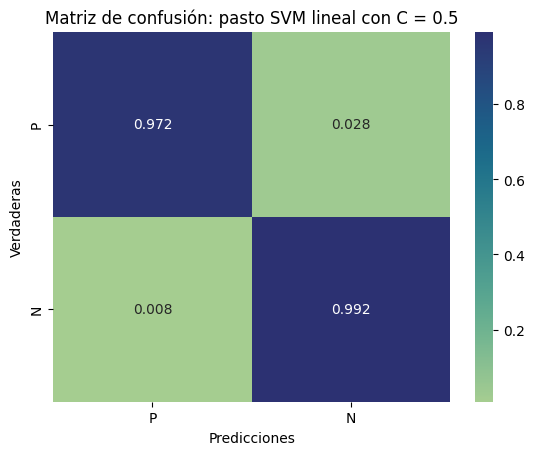

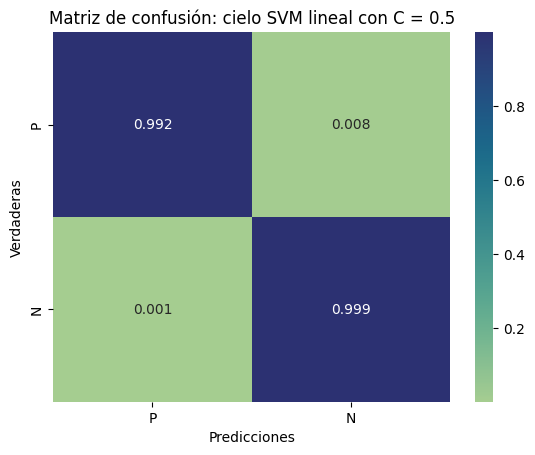

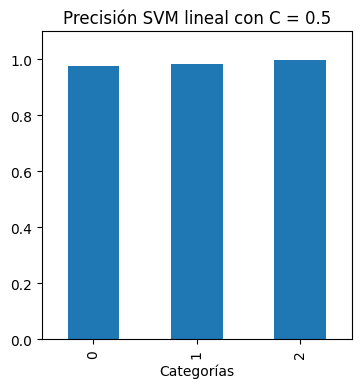

La precisión del clasificador SVM lineal con C = 0.5 es: 0.983


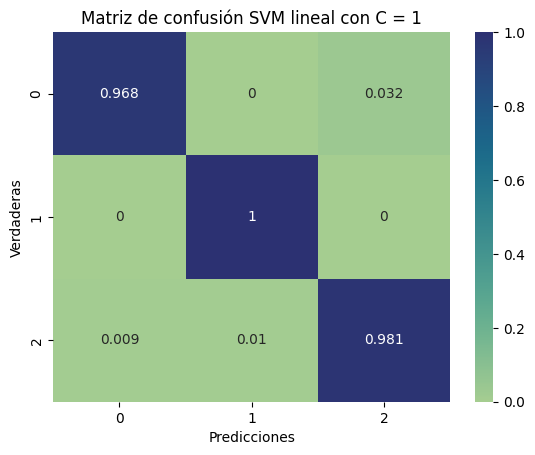

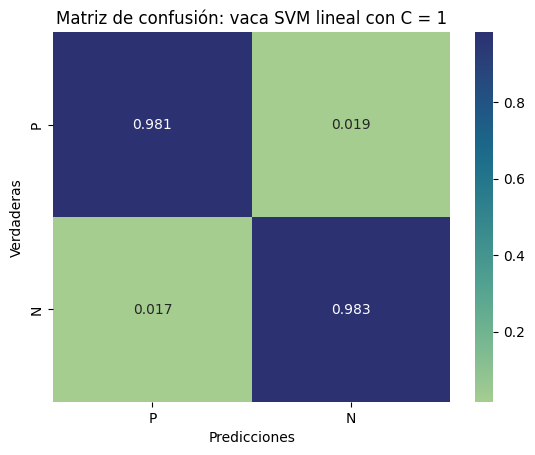

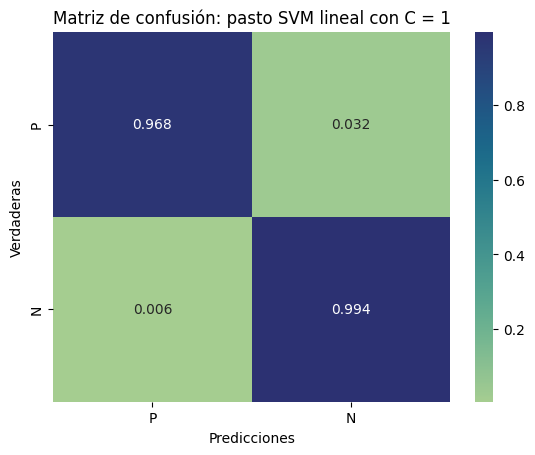

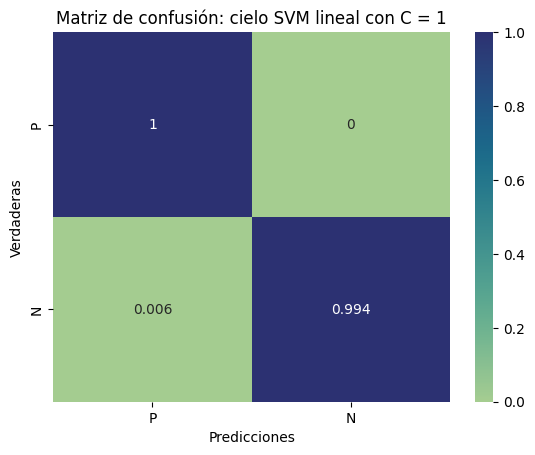

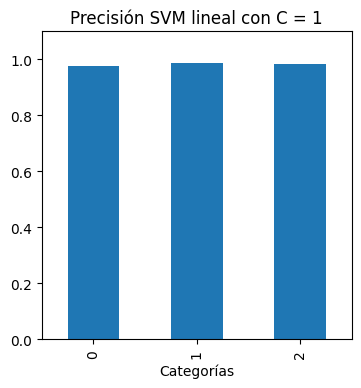

La precisión del clasificador SVM lineal con C = 1 es: 0.982


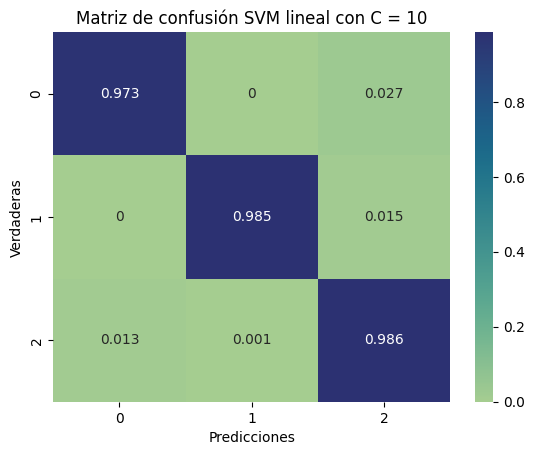

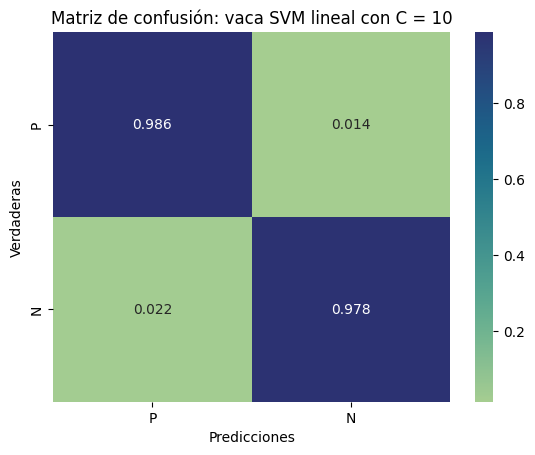

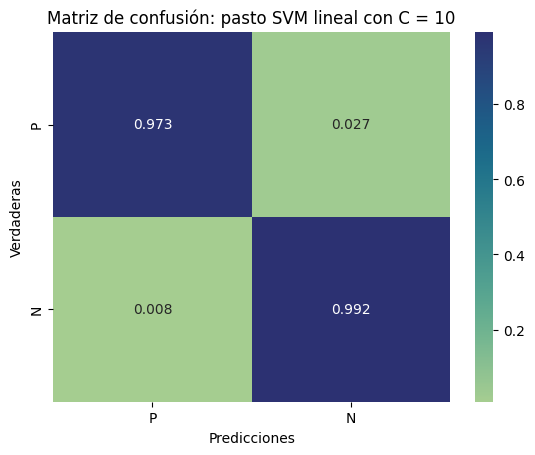

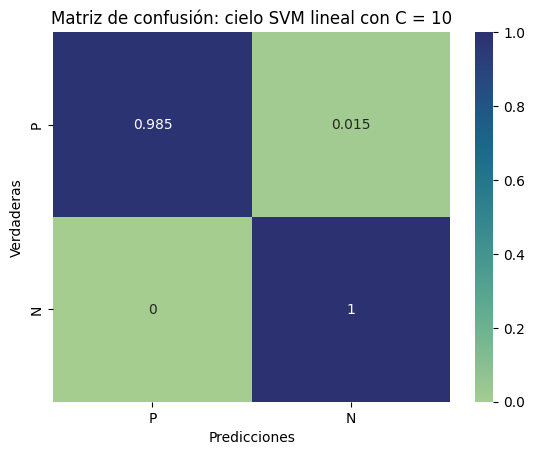

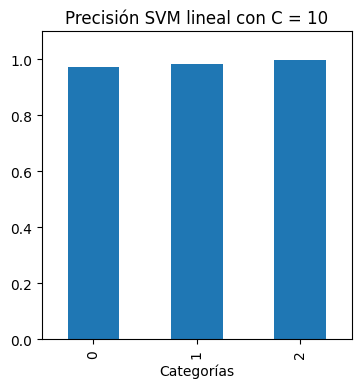

La precisión del clasificador SVM lineal con C = 10 es: 0.982


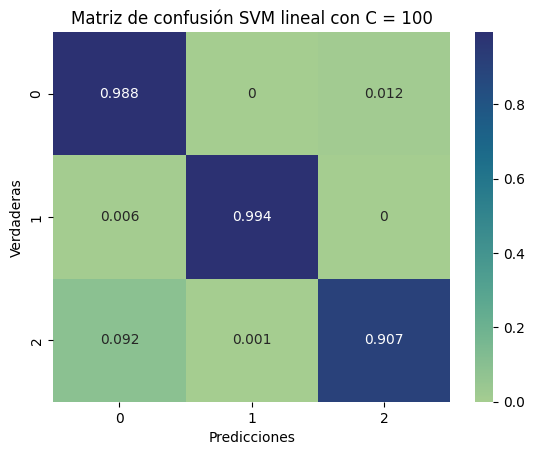

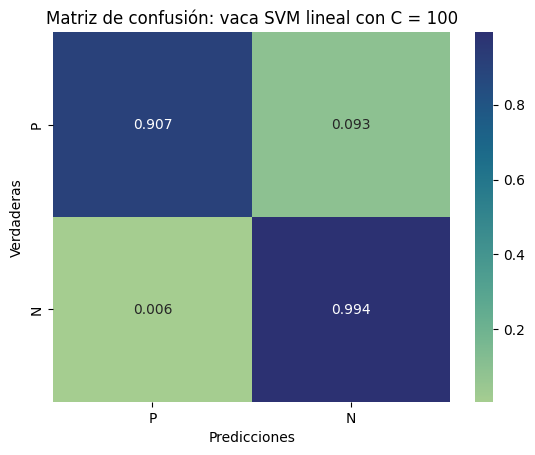

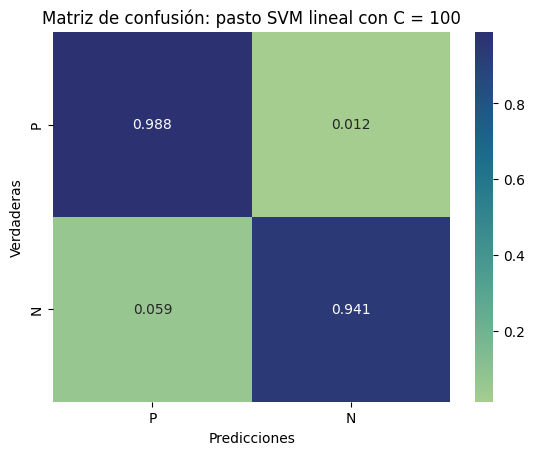

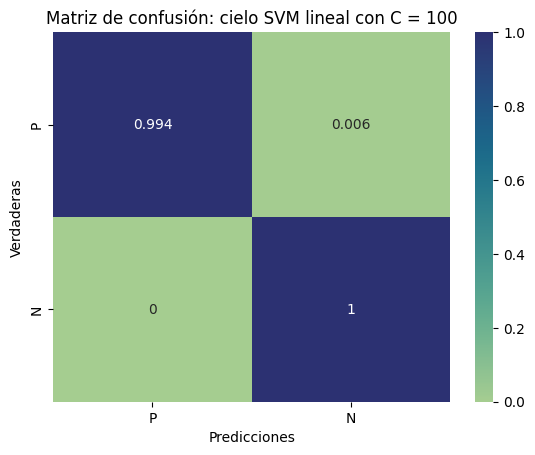

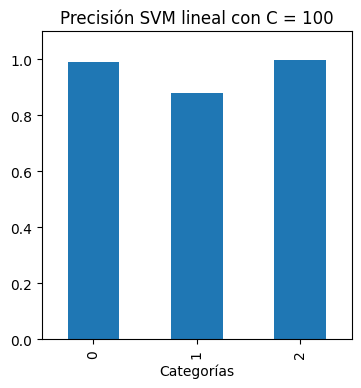

La precisión del clasificador SVM lineal con C = 100 es: 0.955


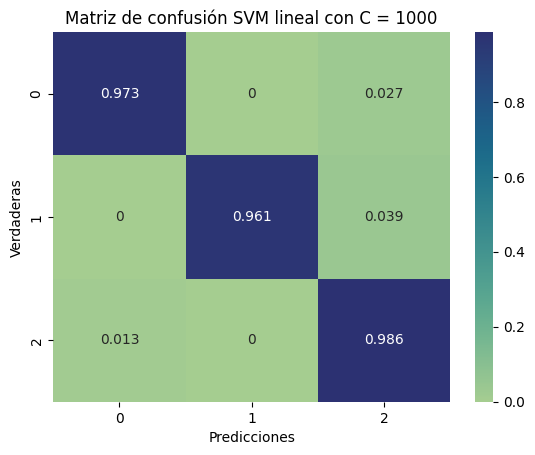

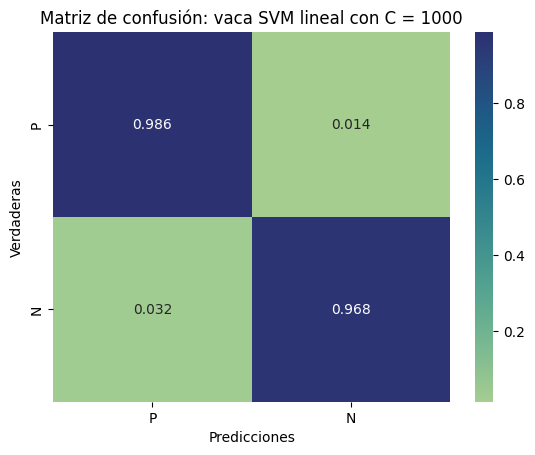

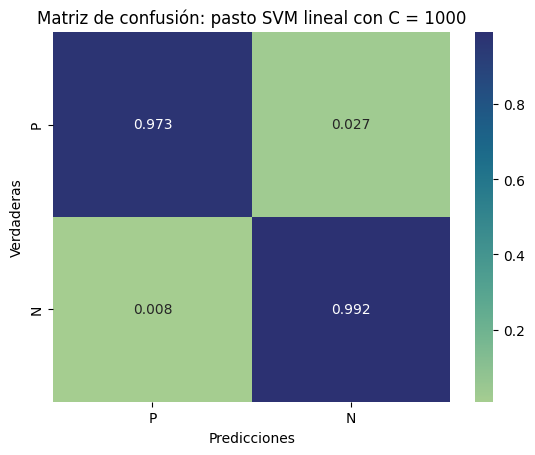

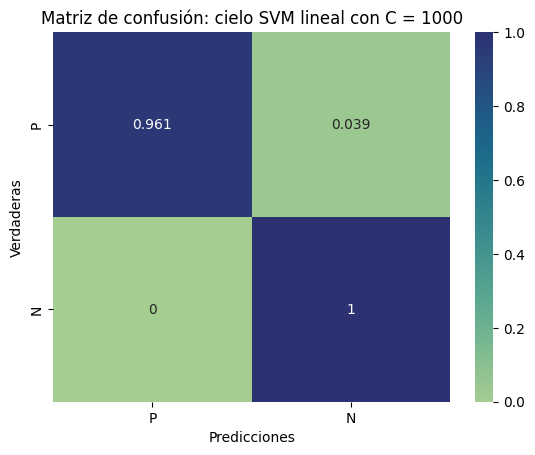

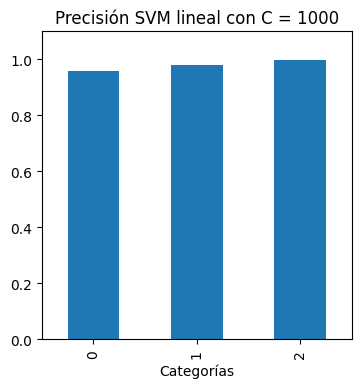

La precisión del clasificador SVM lineal con C = 1000 es: 0.976


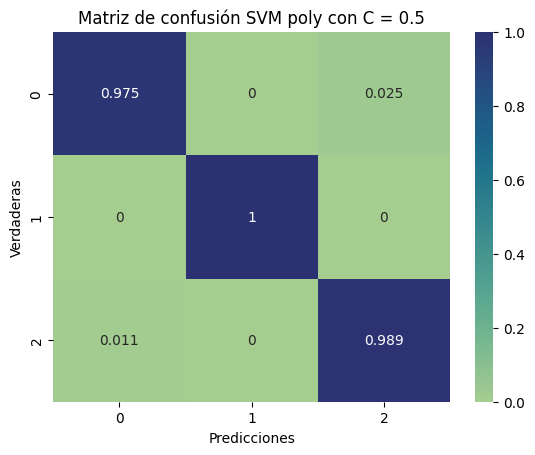

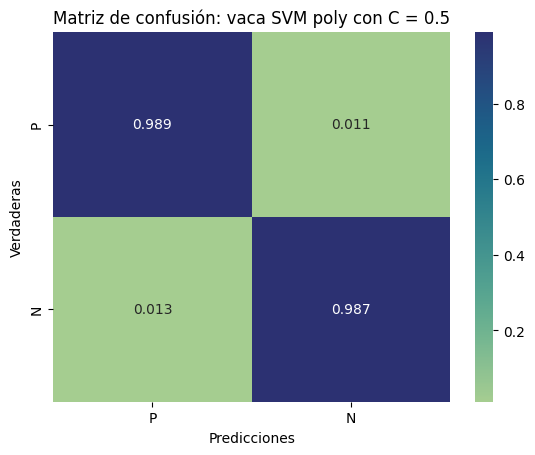

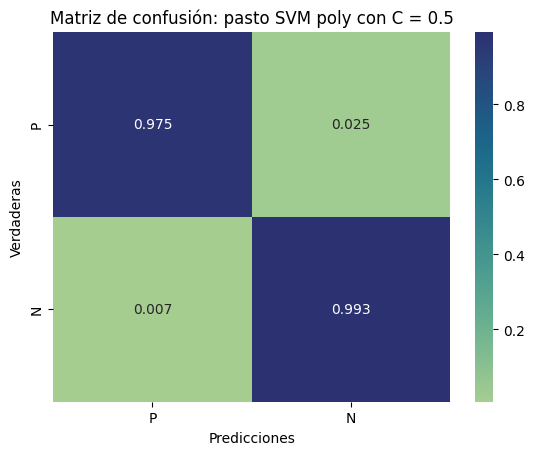

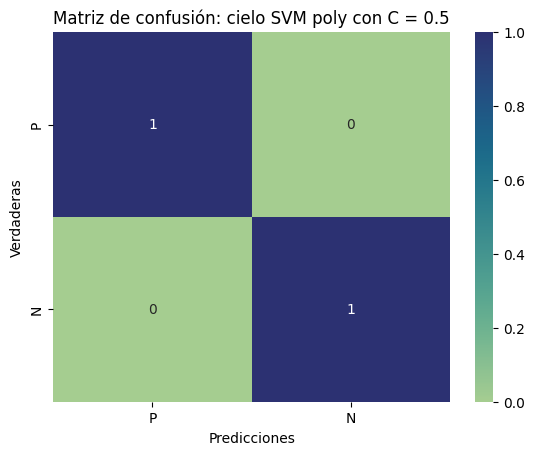

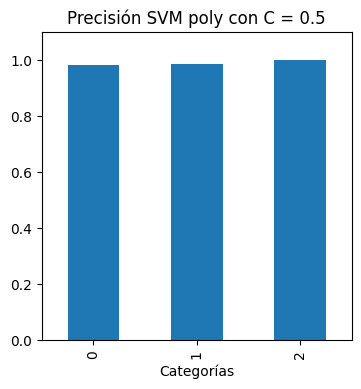

La precisión del clasificador SVM poly con C = 0.5 es: 0.988


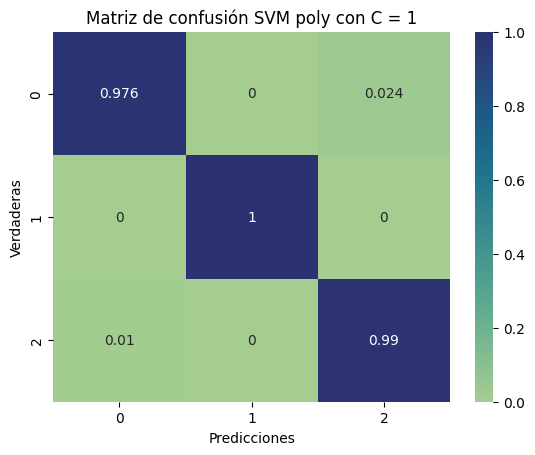

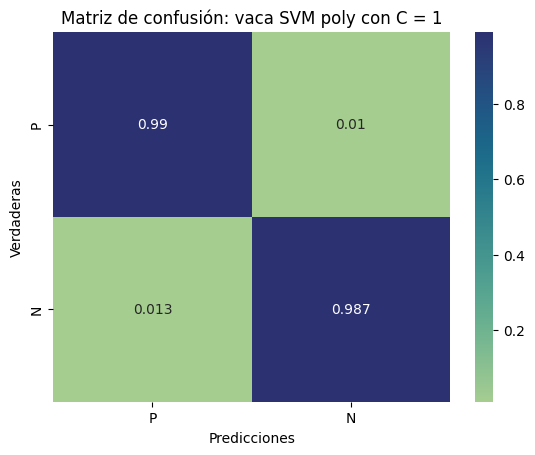

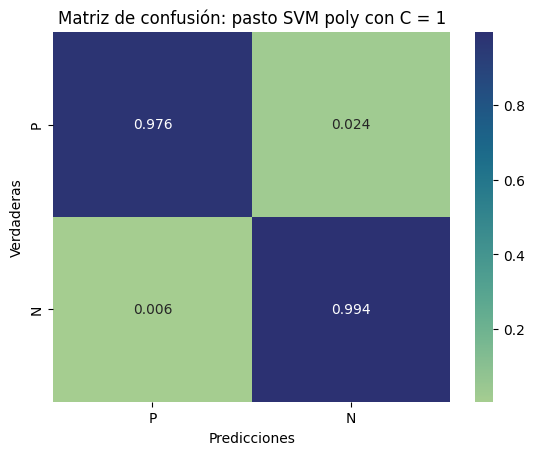

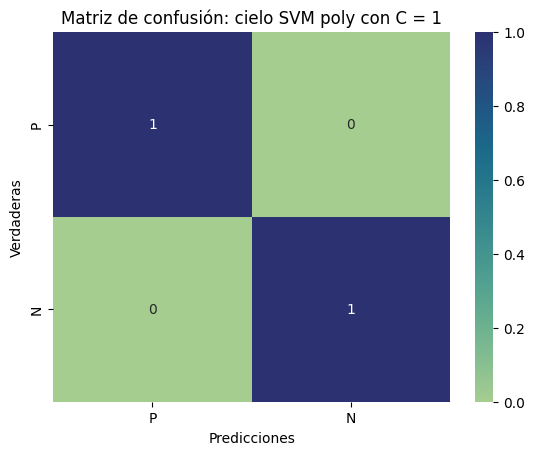

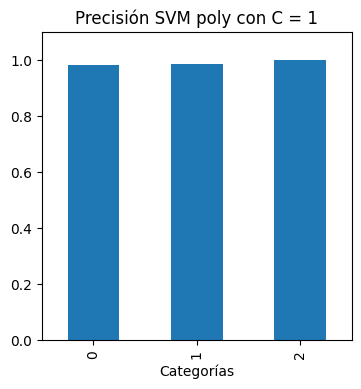

La precisión del clasificador SVM poly con C = 1 es: 0.988


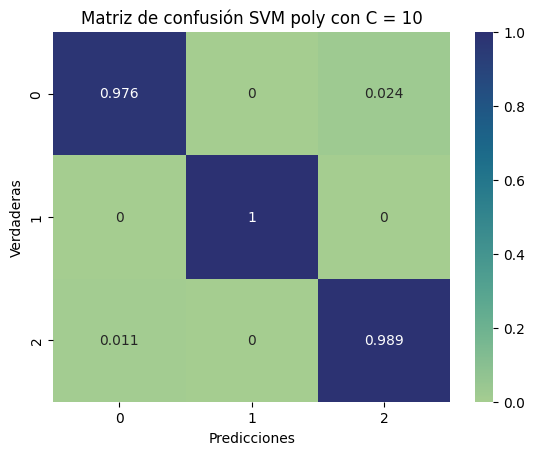

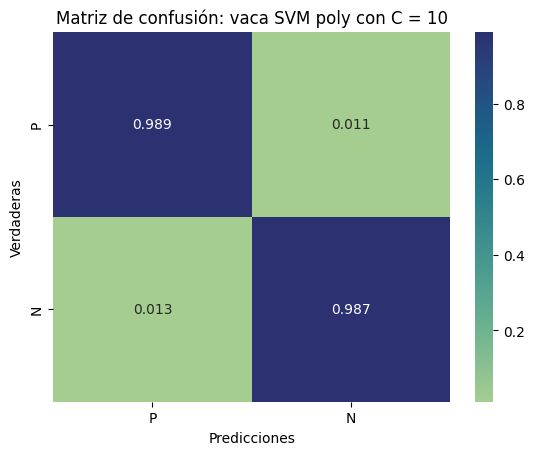

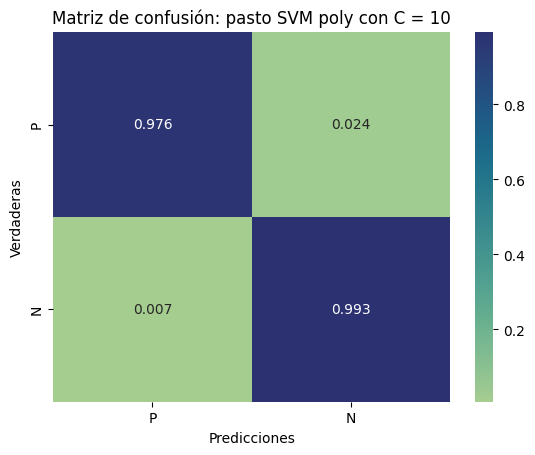

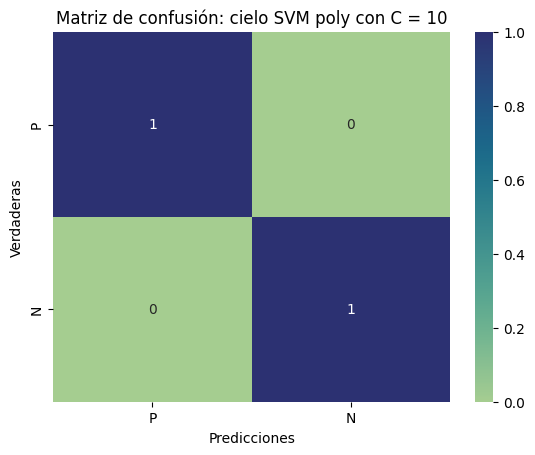

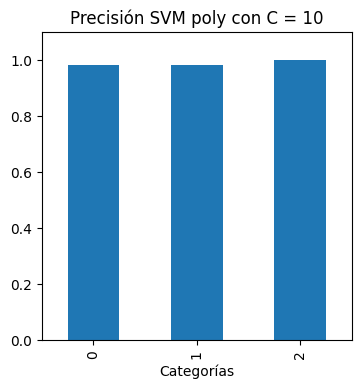

La precisión del clasificador SVM poly con C = 10 es: 0.988


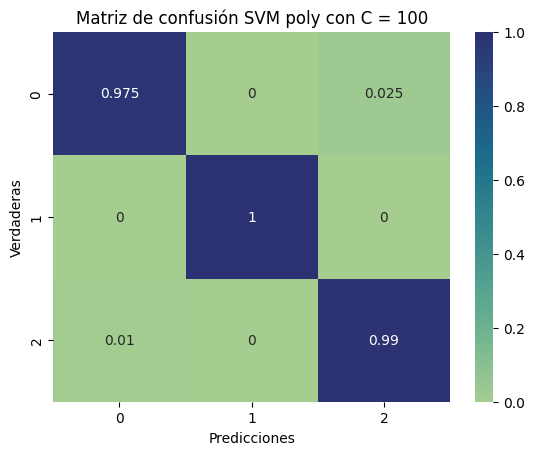

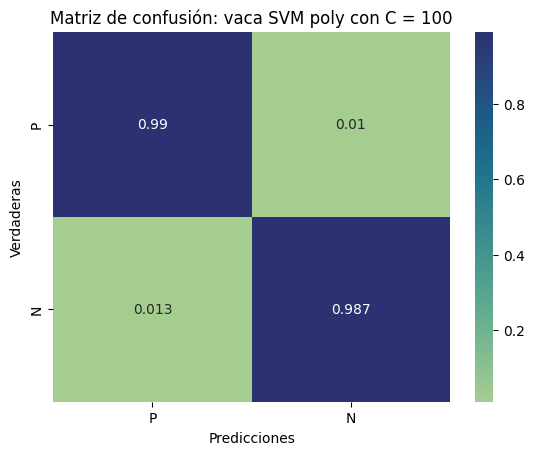

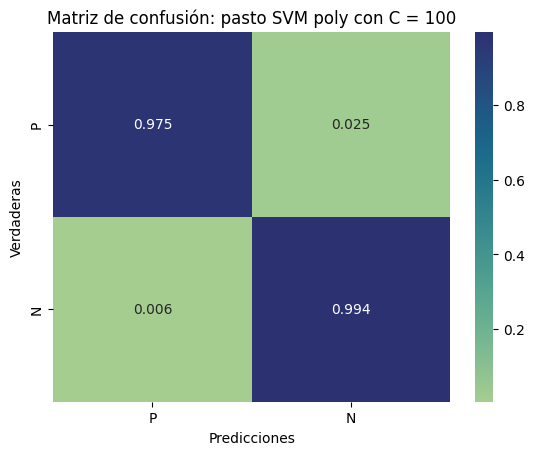

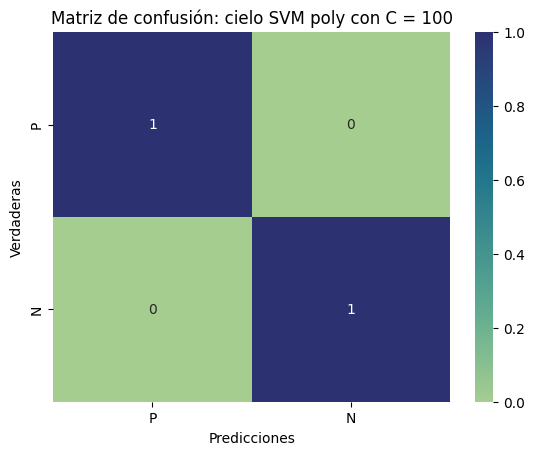

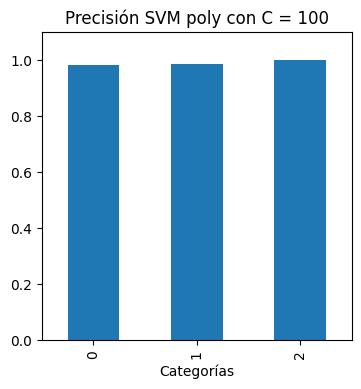

La precisión del clasificador SVM poly con C = 100 es: 0.988


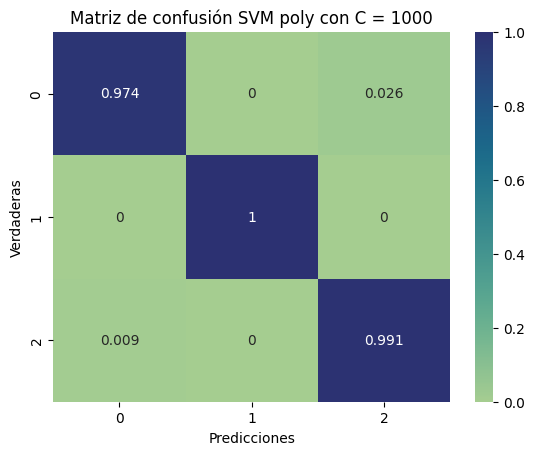

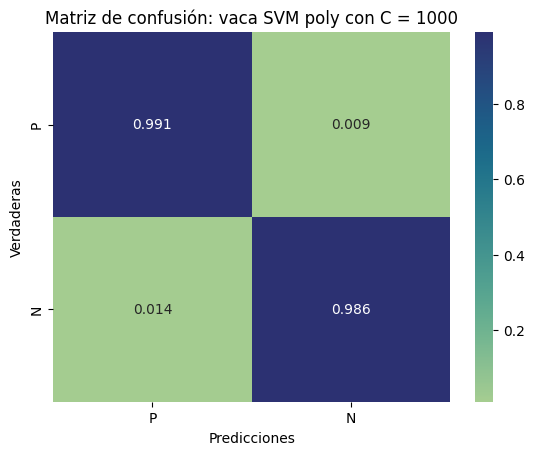

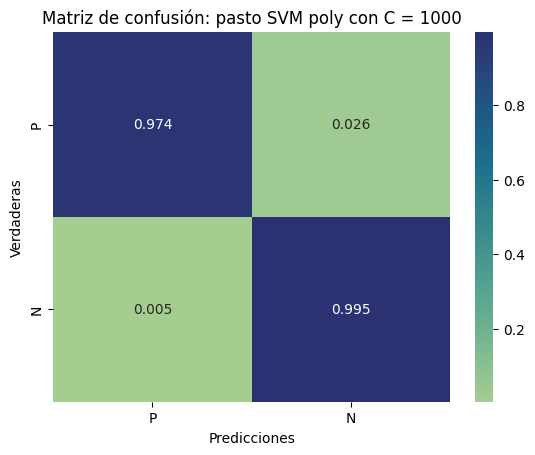

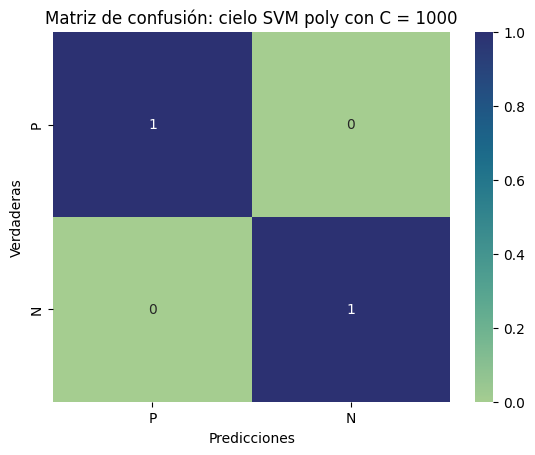

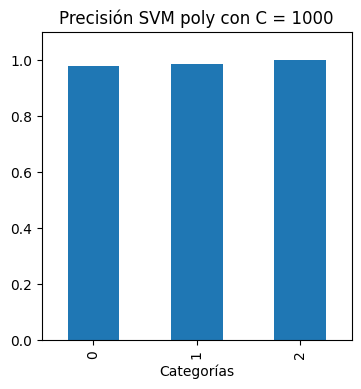

La precisión del clasificador SVM poly con C = 1000 es: 0.988


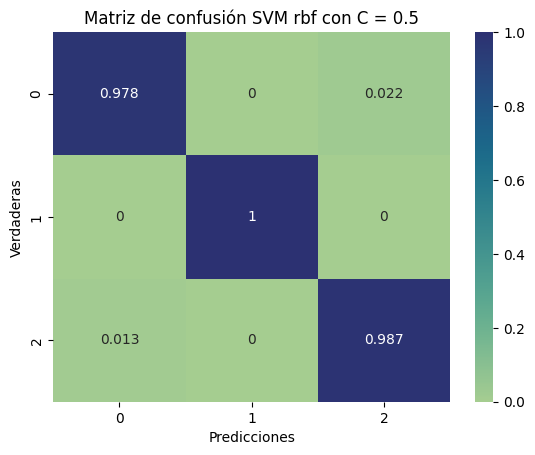

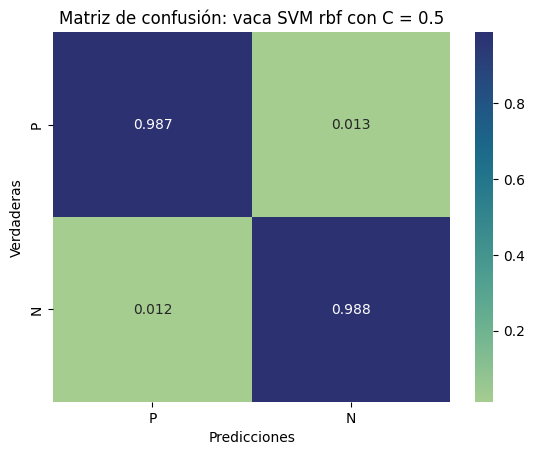

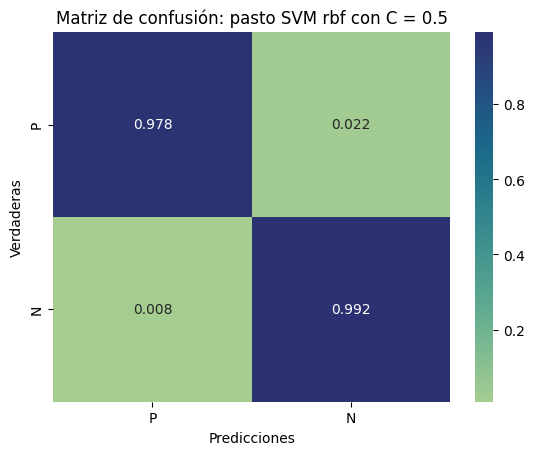

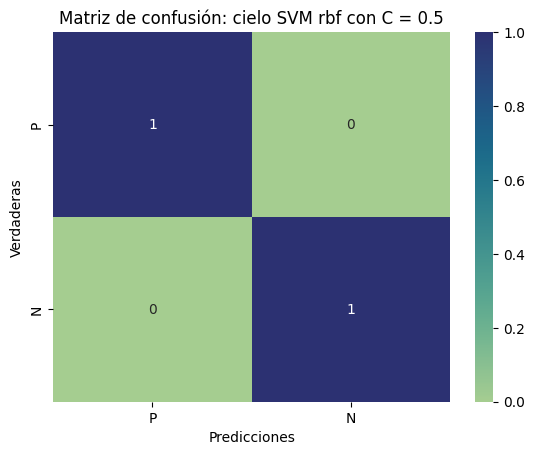

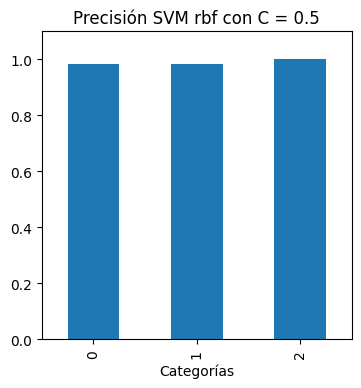

La precisión del clasificador SVM rbf con C = 0.5 es: 0.988


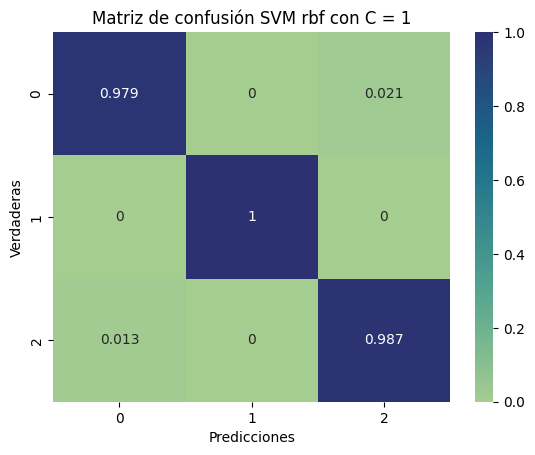

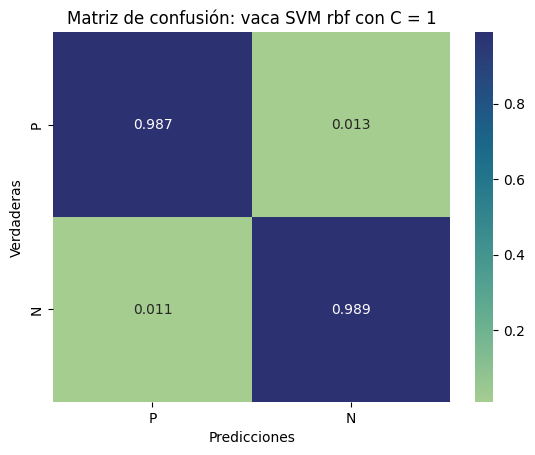

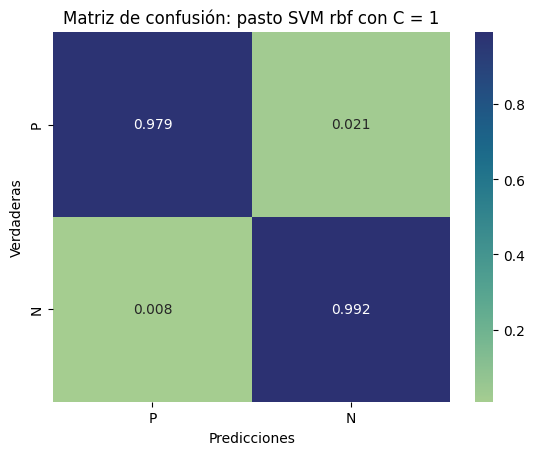

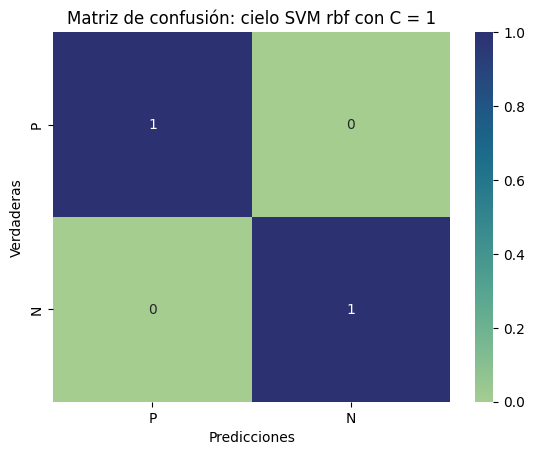

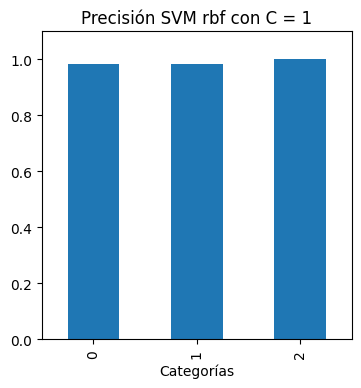

La precisión del clasificador SVM rbf con C = 1 es: 0.988


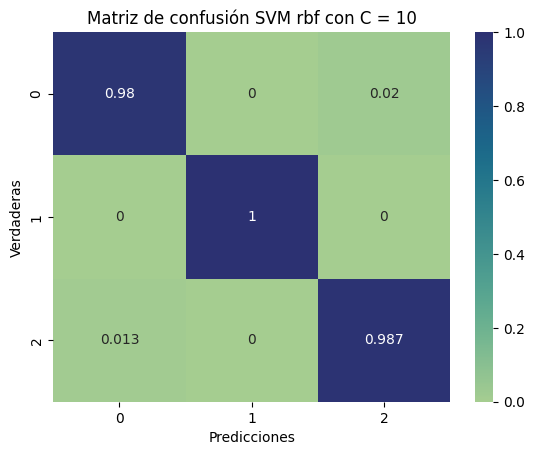

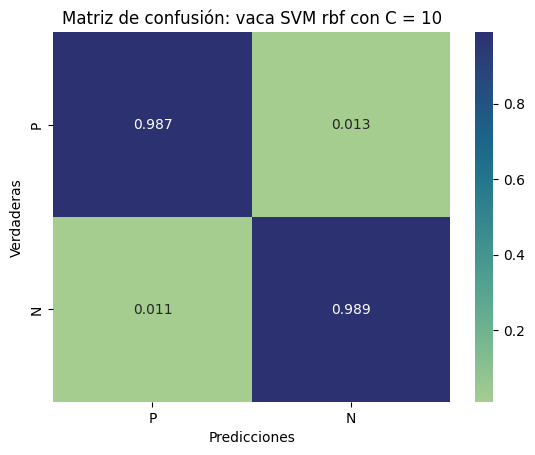

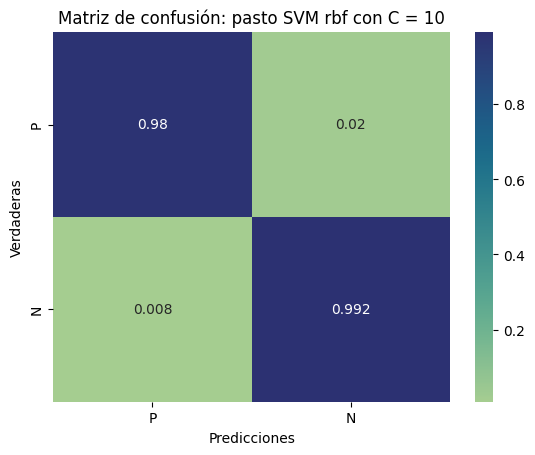

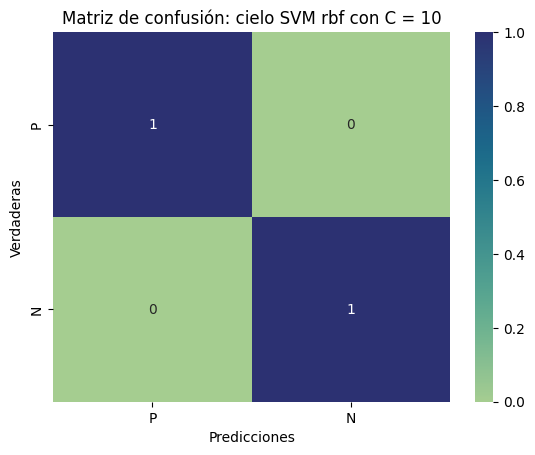

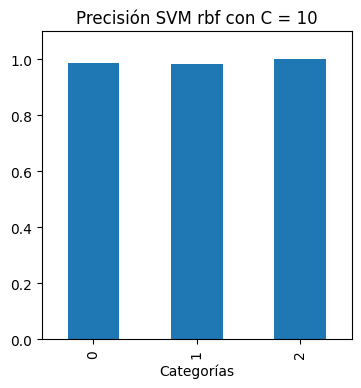

La precisión del clasificador SVM rbf con C = 10 es: 0.988


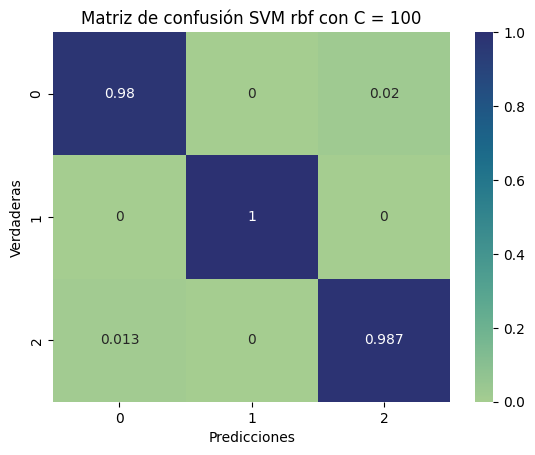

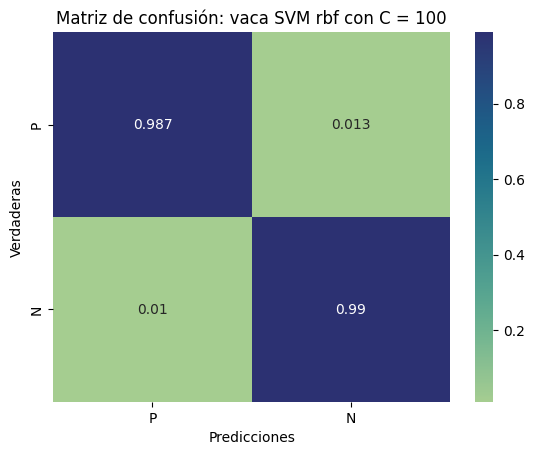

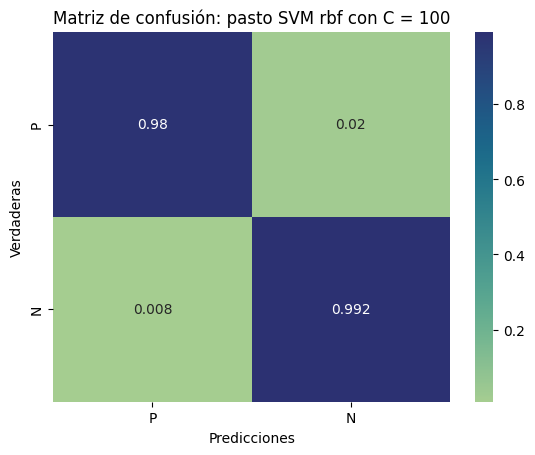

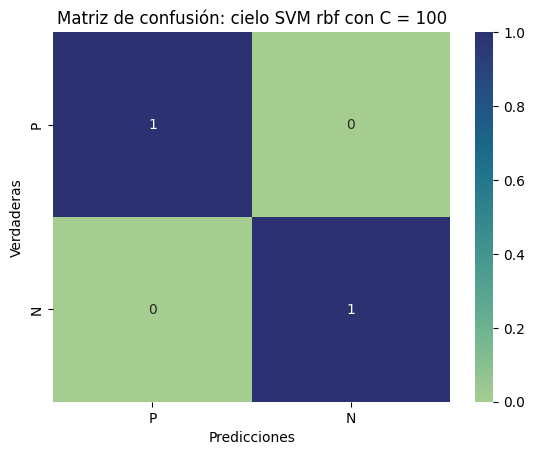

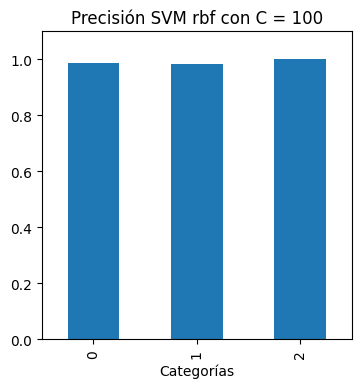

La precisión del clasificador SVM rbf con C = 100 es: 0.989


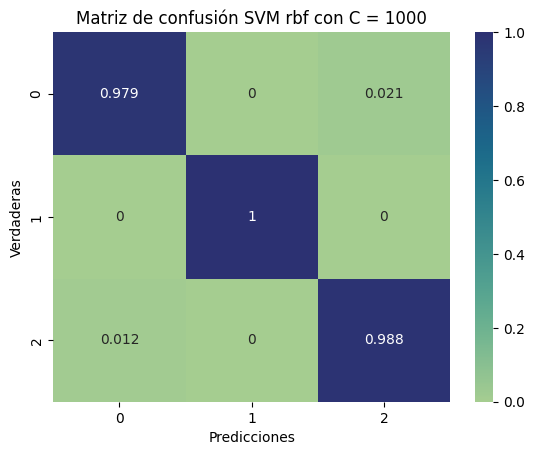

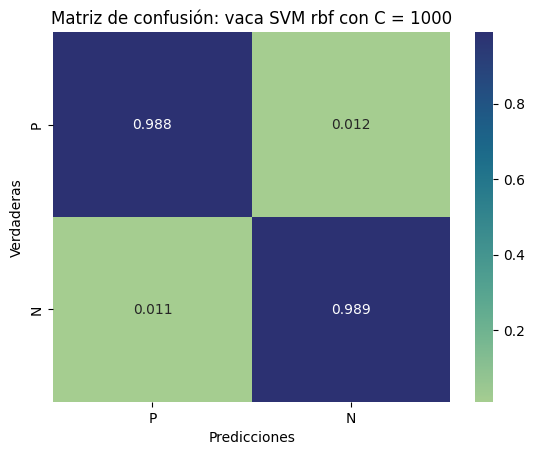

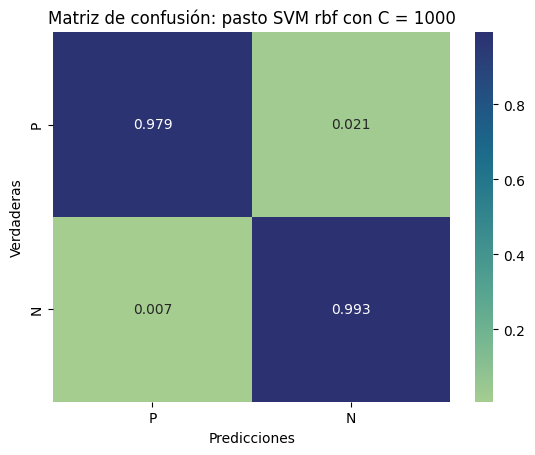

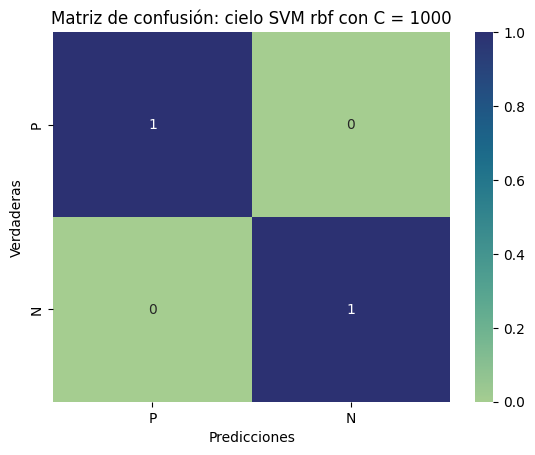

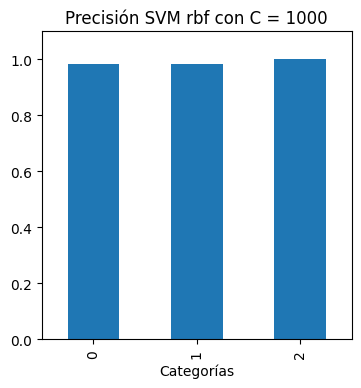

La precisión del clasificador SVM rbf con C = 1000 es: 0.989


In [ ]:
valores_c = [0.5, 1, 10, 100, 1000]
tipos = ["lineal", "poly", "rbf"]

for tipo in tipos:
  for c in valores_c:
    clasificarPixels(x_train, y_train, x_test, y_test, c, tipo)

Los resultados obtenidos a partir de las métricas evaluadas los podemos resumir de la siguiente manera:

* Observando las matrices de confusión de los modelos vemos que a mayor C, mejora un poco la clasificación. Sin embargo, la mejor no es muy alta.
* Respecto a las matrices de confusión para los distintos modelos para la categoría vaca a mayor C los VP aumentan y los VN disminuyen. Es decir, el modelo está mejorando en la detección de casos positivos, pero está cometiendo más errores al clasificar correctamente los casos negativos.
* En cambio, para las matrices de confusión para la categoría pasto ocurre lo inverso al caso previo. A mayor C los VP disminuyen y los VN aumentan. SIn embargo, el cambio no es significativo.
*  Por último para las matrices de confusión del cielo ocurren dos cosas:
 * Para los kernels polinómico y radial, la clasificación del cielo es perfecta y no depende de C

 * Para el lineal cuando C es bajo, clasifica peor al cielo

* Podemos ver que en los gráficos de precisión no cambia mucho ni con C ni con el tipo  de kernel.

* Si comparamos la precisión de los clasificadores tomando todas las clases obtenemos que para el polinómico no afecta C (mantiene la precisión sin importar el cambio de C), para el lineal  a menor C mejor precisión y para el radial a mayor C, mejora la precisión del clasificador.


# e) Clasificar todos los píxels de la imagen

En este ítem coloreamos los píxeles según su clasificación para ver de manera visual si el algoritmo puedo clasificar bien la vaca, el pasto y el cielo. Pintamos de marrón a aquellos píxeles clasificados como vaca, de verde al pasto y de celeste al cielo.

## Funciones

In [ ]:
def predecirImg(imagen, clf, c, tipo):
  altura, ancho, canales = imagen.shape
  imagen_rs = np.reshape(imagen, (altura * ancho, canales))
  df_imagen = pd.DataFrame(imagen_rs, columns=["R", "G", "B"])
  y_pred = np.array(clf.predict(df_imagen))
  imagen_pred = y_pred.reshape(np.shape(imagen[:,:,0]))

  marron = np.array([119, 61, 11])
  verde = np.array([24, 185, 51])
  azul = np.array([58, 203, 255])

  colores = np.zeros_like(imagen)
  colores[np.where(imagen_pred == 0)] = marron
  colores[np.where(imagen_pred == 1)] = verde
  colores[np.where(imagen_pred == 2)] = azul

  plt.figure()
  plt.imshow(colores.astype(int))
  plt.title(f"Imagen reconstruida SVM {tipo} con C = {c}")
  plt.show()

  return

In [ ]:
def resultadosImg(imagen, x_train, y_train, x_test, y_test, c, tipo):
  # Calcular modelo y predecir
  y_pred, clf = calcularModelo(x_train, y_train, x_test, tipo, c)

  # Colorear imagen
  predecirImg(imagen, clf, c, tipo)

  # Métricas
  calcularMatrizConfusion(y_pred, np.array(y_test), tipo, c)
  P_N_categorias = matrices_confusion(y_pred, np.array(y_test), tipo, c)
  metricas_categorias = metricas(P_N_categorias, tipo, c)
  precision_modelo = precisionClasificador(P_N_categorias)
  print(f"La precisión del clasificador SVM {tipo} con C = {c} es: {round(precision_modelo, 3)}")

  return

## RBF

Obtuvimos los resultados del kernel radial para C=1000.

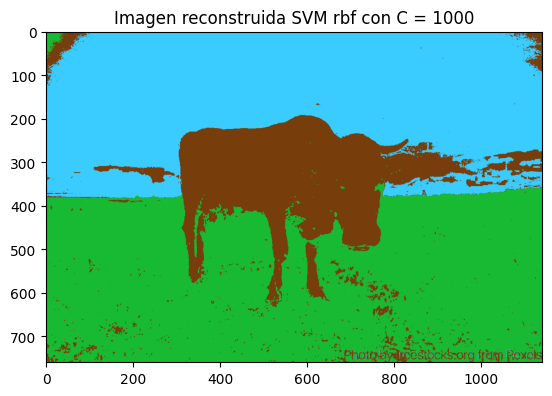

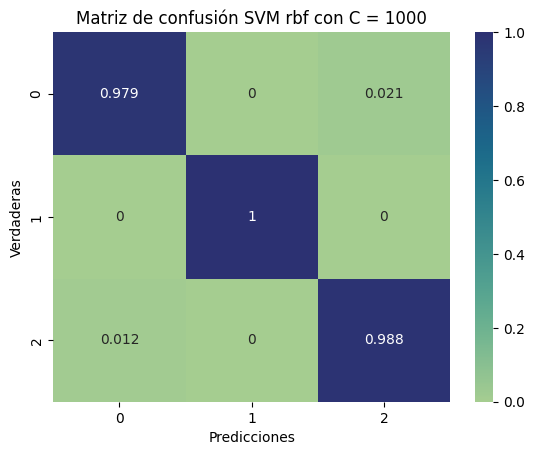

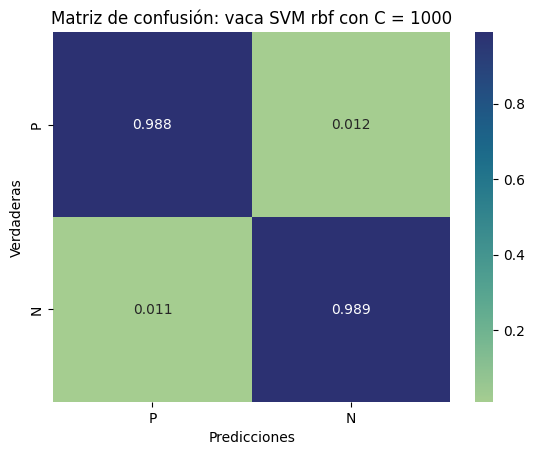

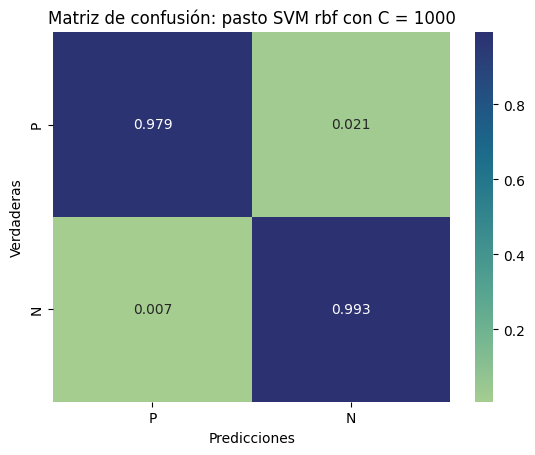

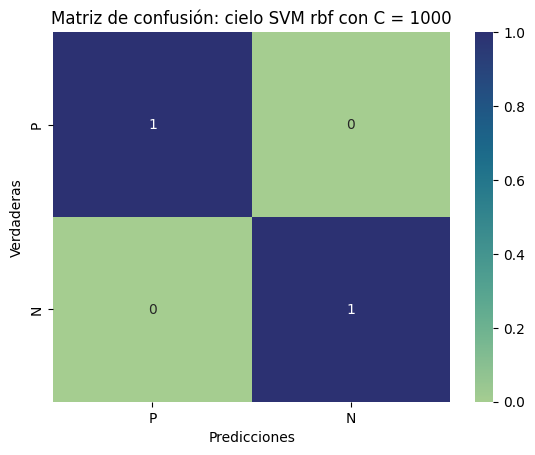

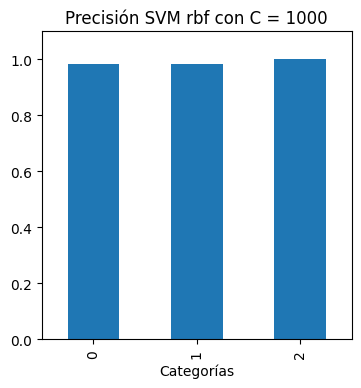

La precisión del clasificador SVM rbf con C = 1000 es: 0.989


In [ ]:
resultadosImg(imagen_RGB, x_train, y_train, x_test, y_test, c=1000, tipo="rbf")

## Lineal

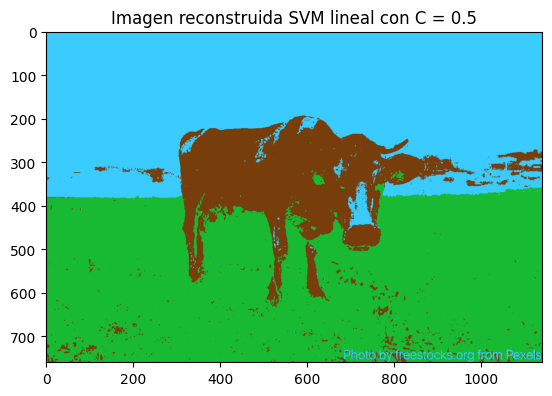

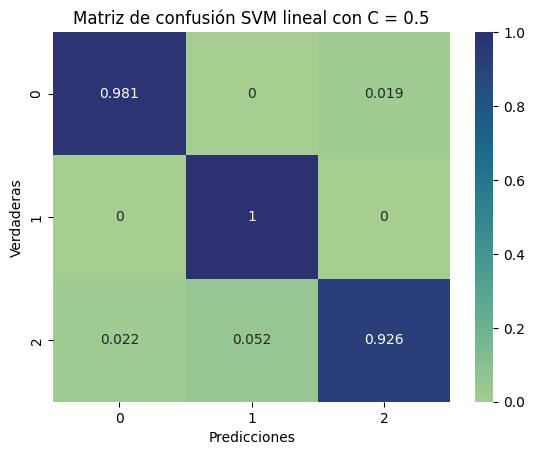

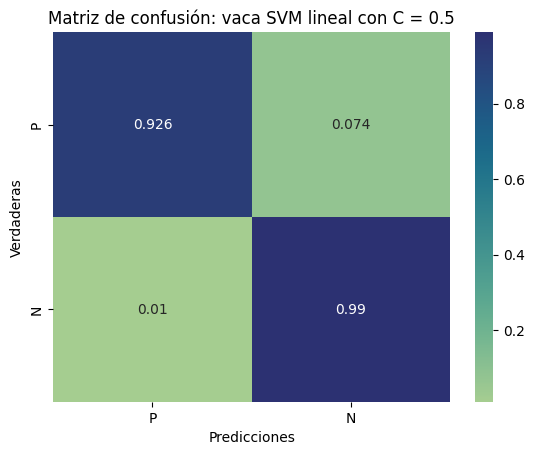

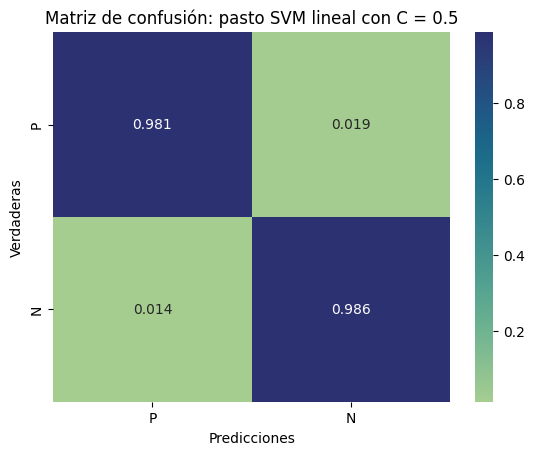

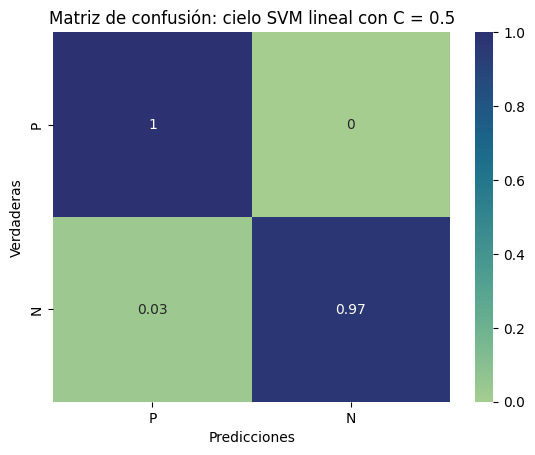

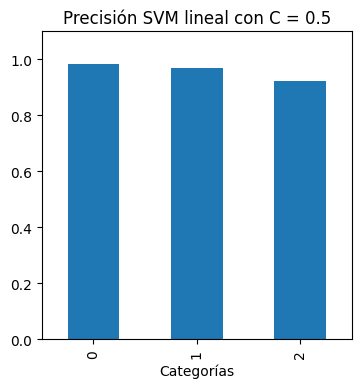

La precisión del clasificador SVM lineal con C = 0.5 es: 0.963


array([0, 2, 1, ..., 1, 0, 0])

In [ ]:
resultadosImg(imagen_RGB, x_train, y_train, x_test, y_test, c=0.5, tipo="lineal")

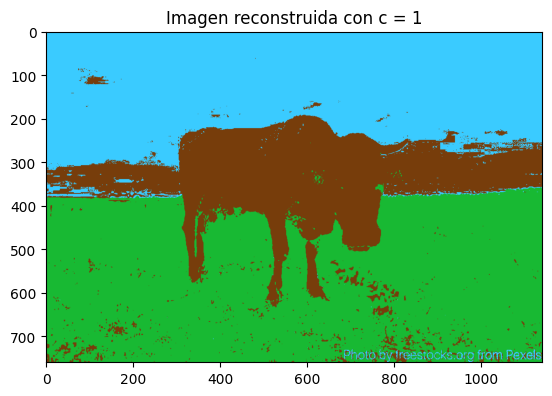

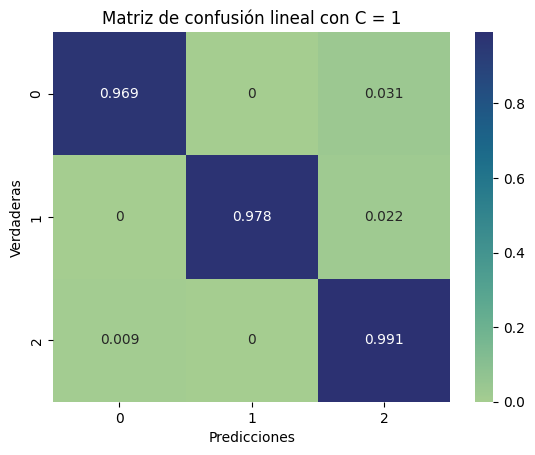

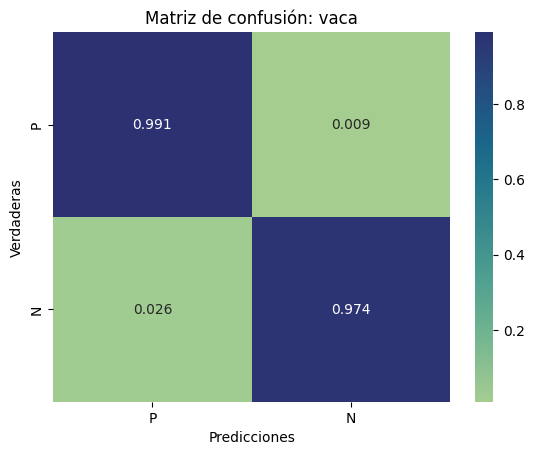

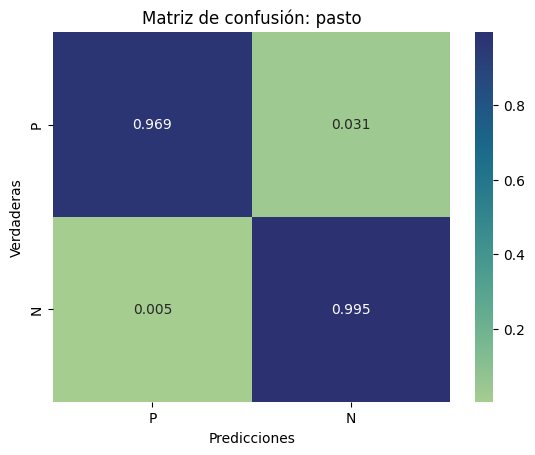

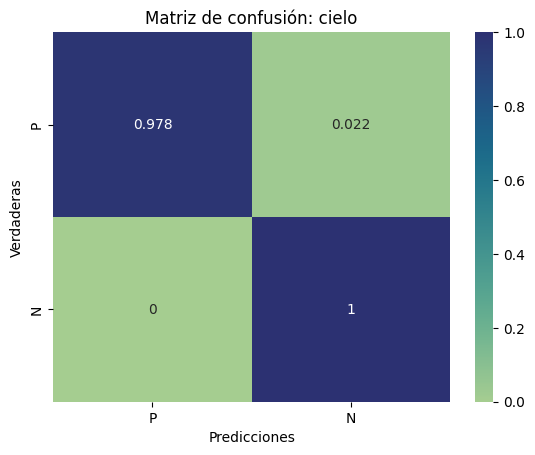

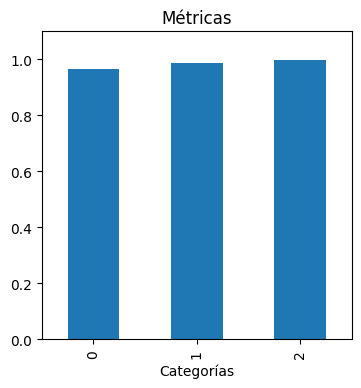

La precisión del clasificador SVM lineal es: 0.981


In [ ]:
resultadosImg(imagen_RGB, x_train, y_train, x_test, y_test, c=1, tipo="lineal")

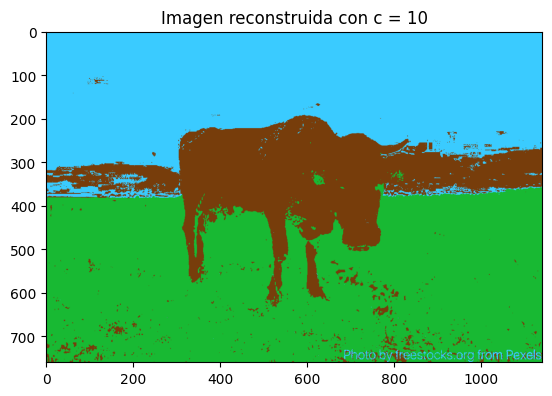

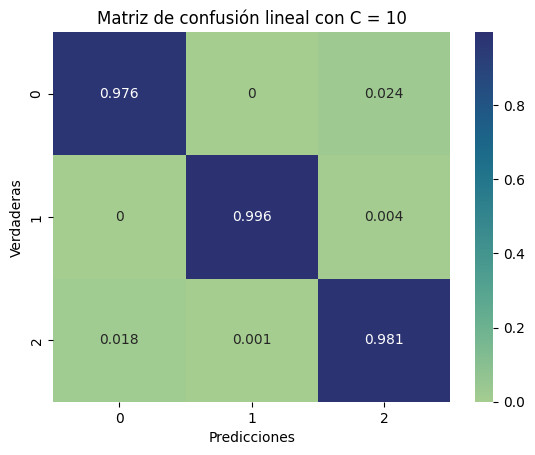

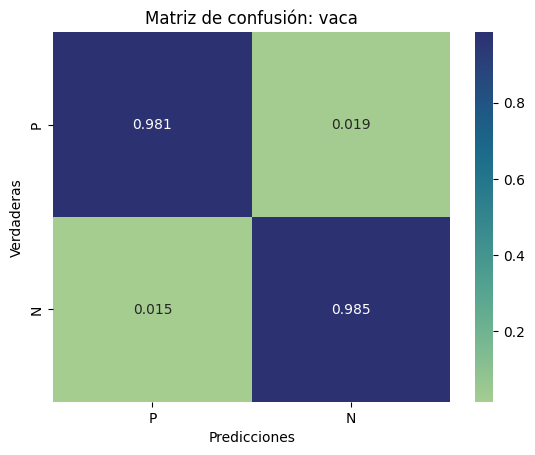

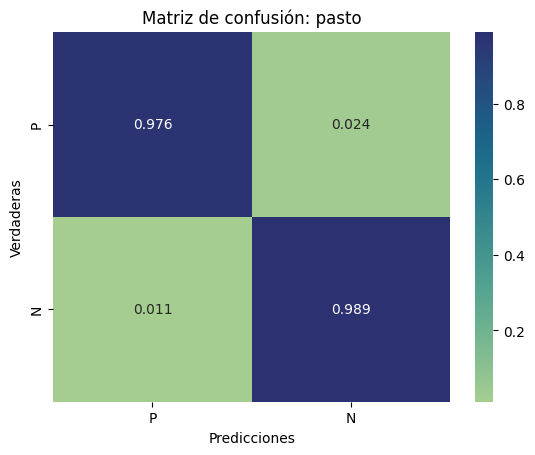

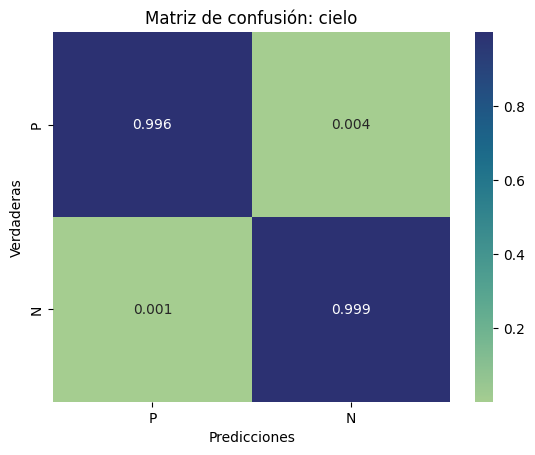

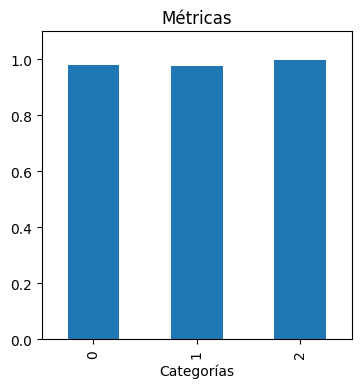

La precisión del clasificador SVM lineal es: 0.983


In [ ]:
resultadosImg(imagen_RGB, x_train, y_train, x_test, y_test, c=10, tipo="lineal")

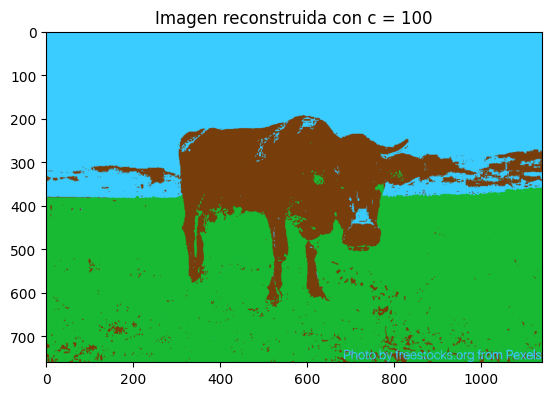

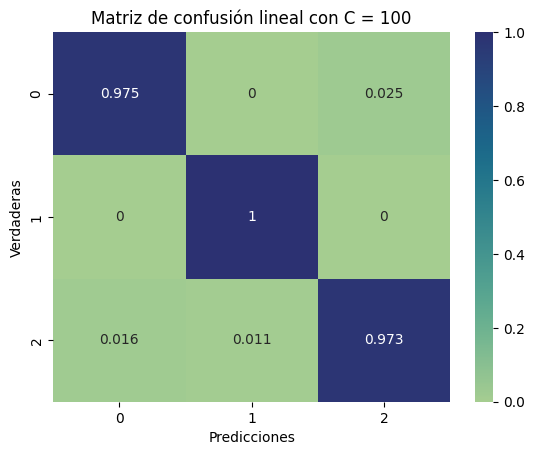

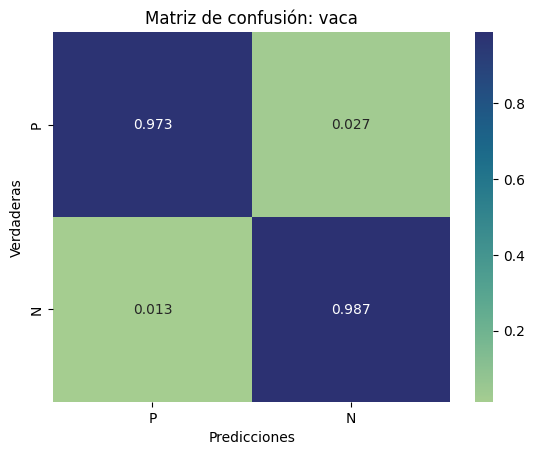

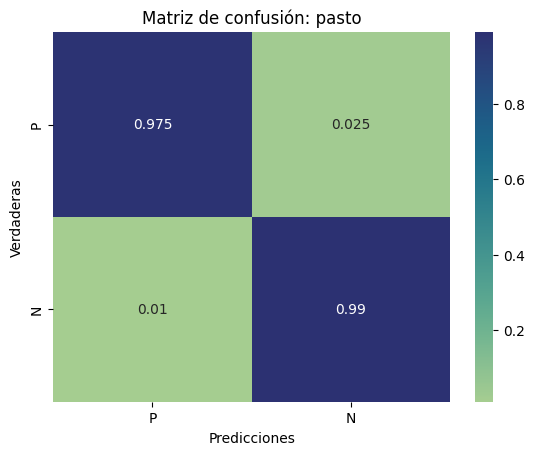

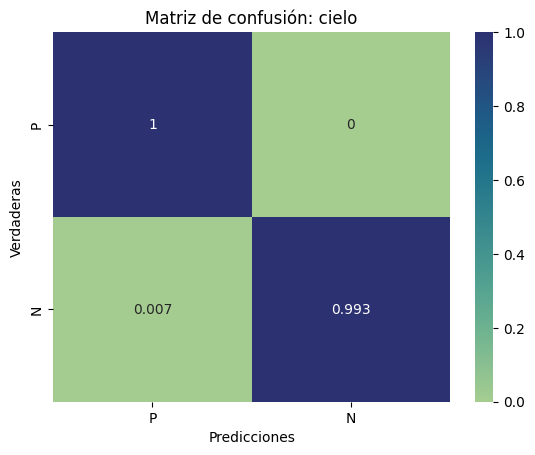

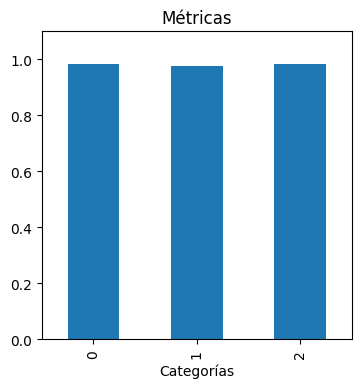

La precisión del clasificador SVM lineal es: 0.981


In [ ]:
resultadosImg(imagen_RGB, x_train, y_train, x_test, y_test, c=100, tipo="lineal")

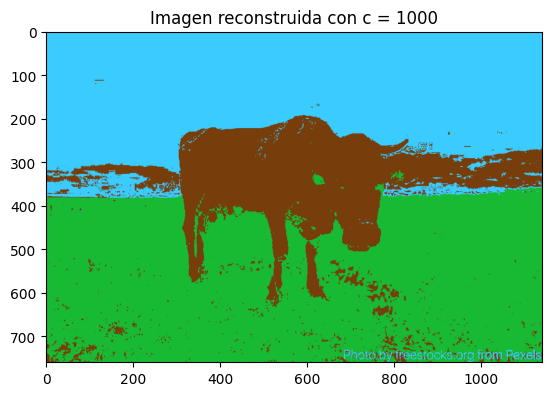

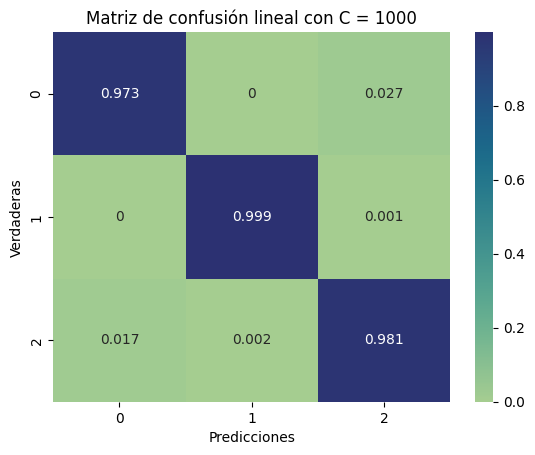

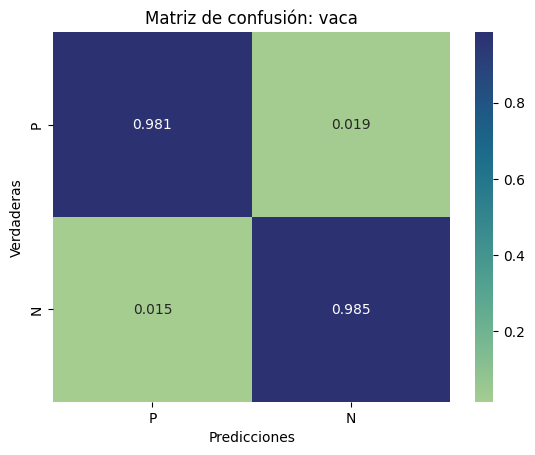

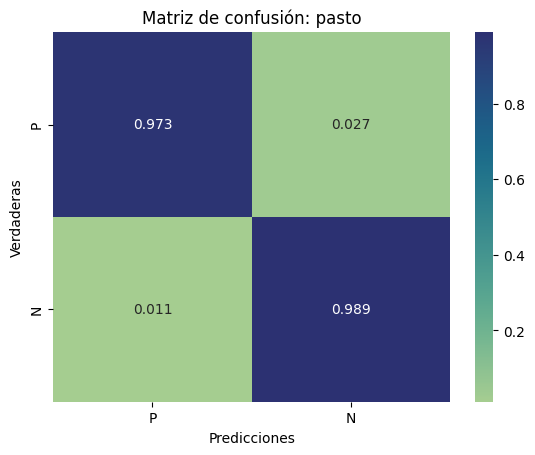

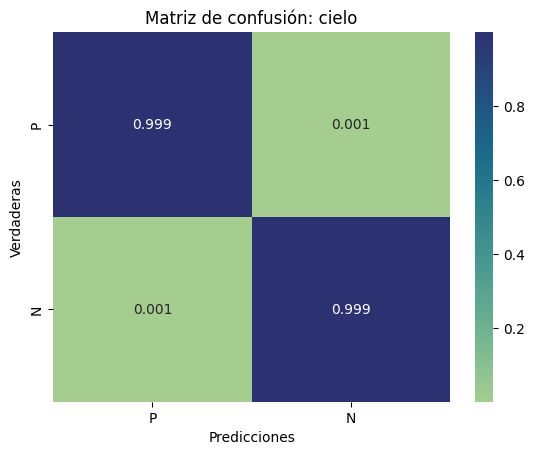

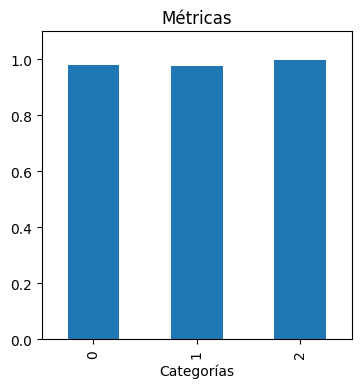

La precisión del clasificador SVM lineal es: 0.983


In [ ]:
resultadosImg(imagen_RGB, x_train, y_train, x_test, y_test, c=1000, tipo="lineal")

## Polinómico

Clasificamos los píxeles usando un kernel polinómico de grado 3 con C=1000.

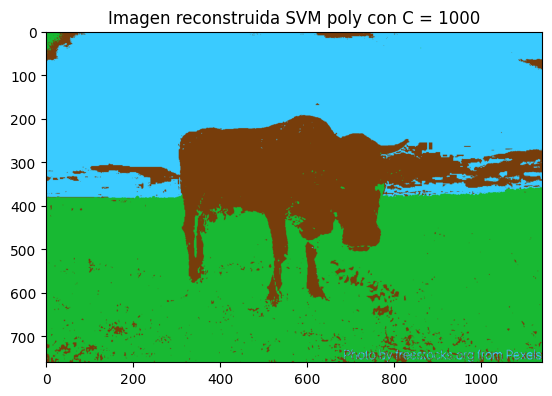

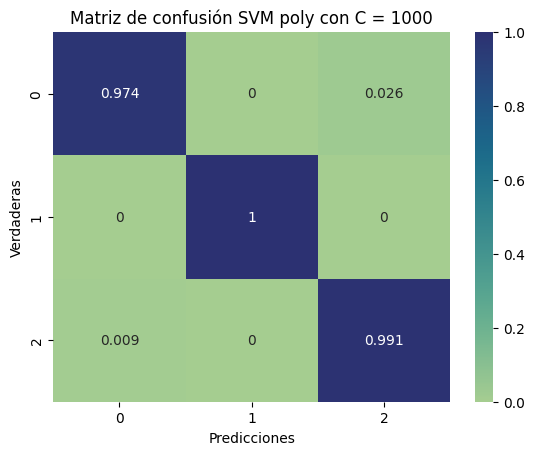

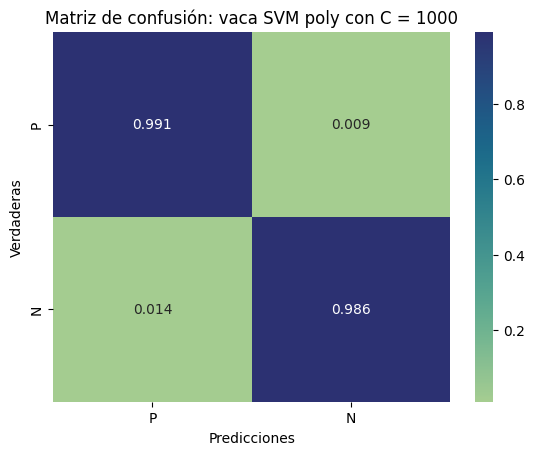

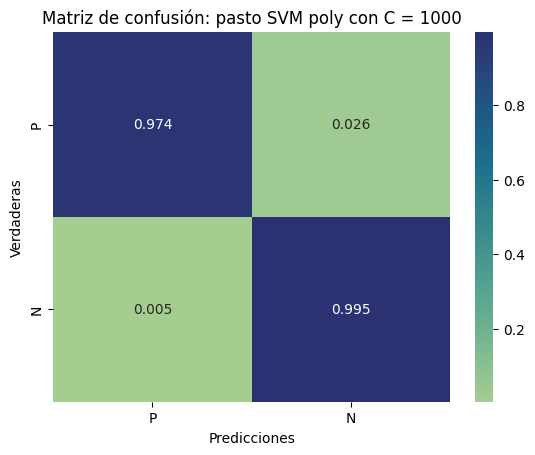

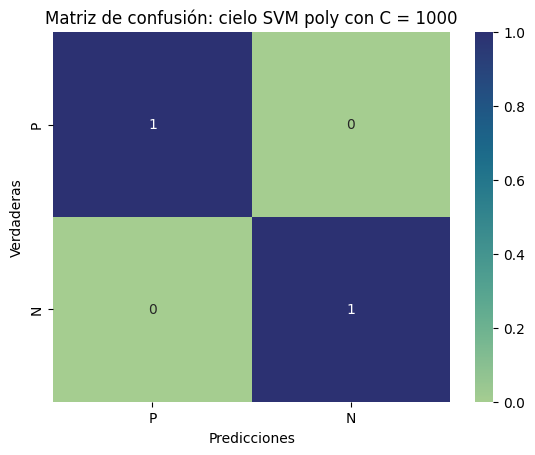

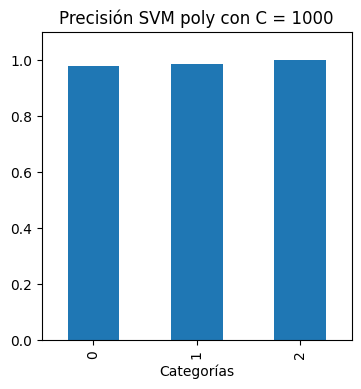

La precisión del clasificador SVM poly con C = 1000 es: 0.988


In [ ]:
resultadosImg(imagen_RGB, x_train, y_train, x_test, y_test, c=1000, tipo="poly")

En la imagen orignial la distribución de los datos es compleja, por eso el kernel radial obtuvo mejores resultados. El kernel radial tiene la capacidad de adaptarse a diferentes distribuciones y formas de los datos. Debido a su naturaleza no lineal, puede capturar patrones complejos y representar fronteras de decisión más flexibles.

Por otro lado, las malas clasificacion de algunos píxeles de la vaca respecto al cielo se epuede deber a que el cielo tiene nubes de color blanco similares a las macnhas de la vaca.


# f) Utilizando otras imágenes

Probamos el algoritmo con otras imágenes de vacas. 

## Imágenes

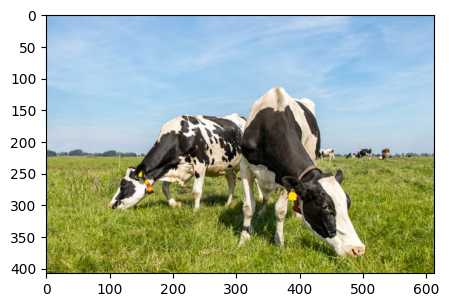

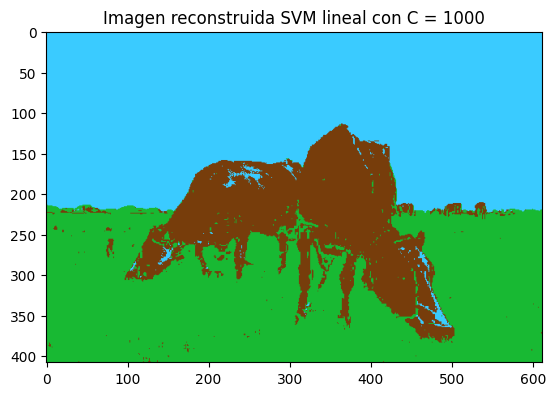

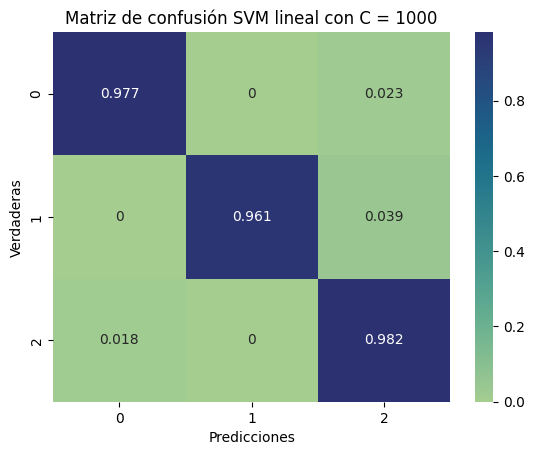

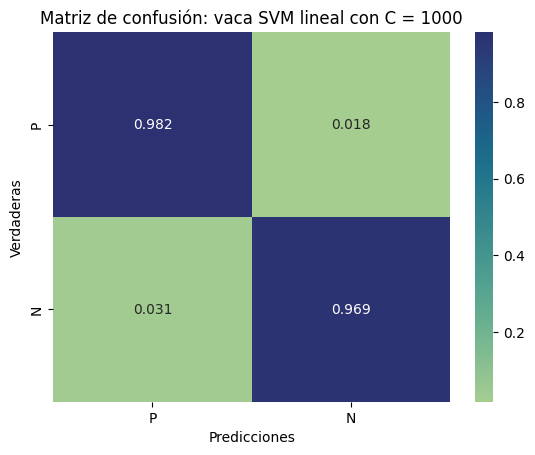

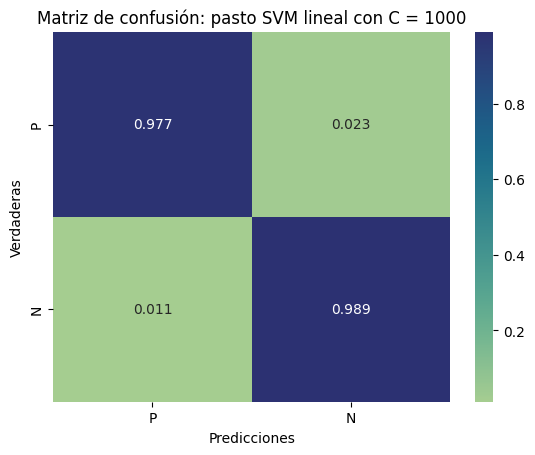

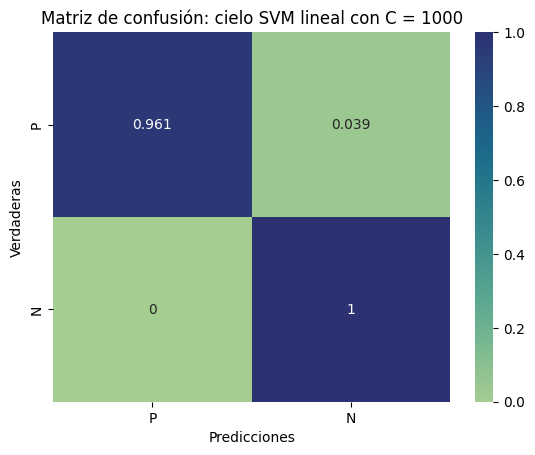

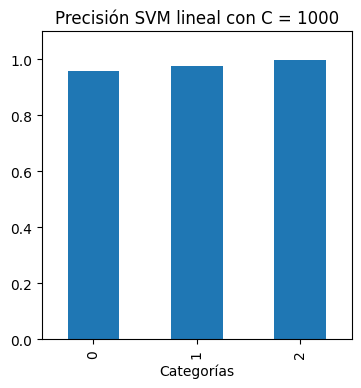

La precisión del clasificador SVM lineal con C = 1000 es: 0.975


array([0, 2, 1, ..., 1, 0, 0])

In [ ]:
imagen_1 = cv2.imread('/content/drive/MyDrive/Grupo 3 ML/TP3/Ejercicio 2/Otras vacas/1.jpg',1) #con 1 la leemos a color
imagen_RGB_1 = cv2.cvtColor(imagen_1, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(imagen_RGB_1)
plt.show()

resultadosImg(imagen_RGB_1, x_train, y_train, x_test, y_test, c=1000, tipo="lineal")

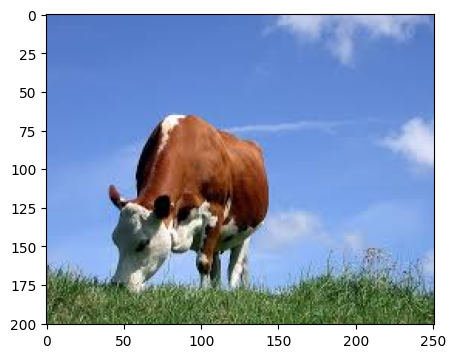

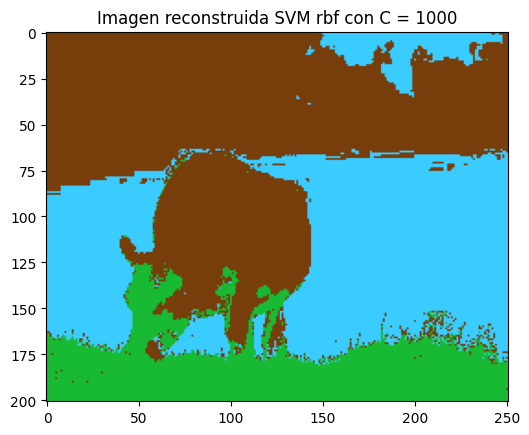

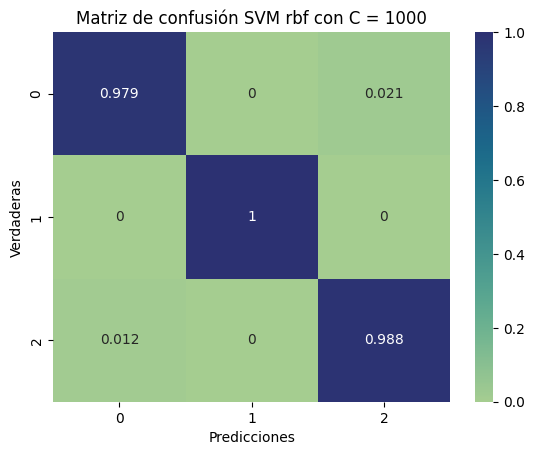

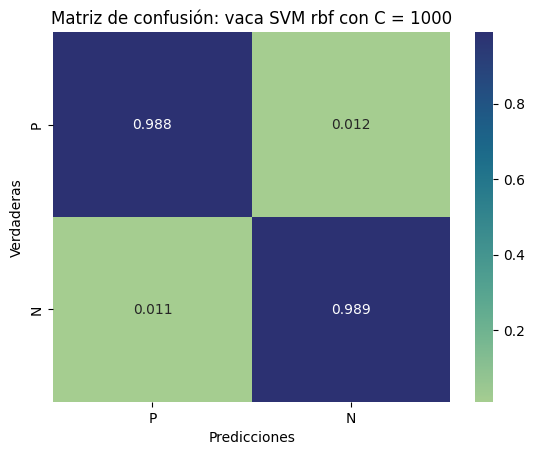

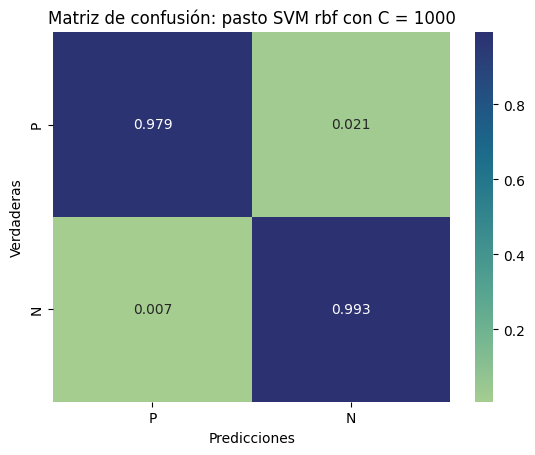

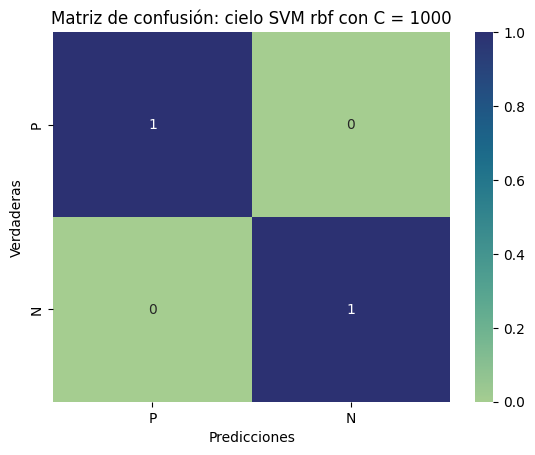

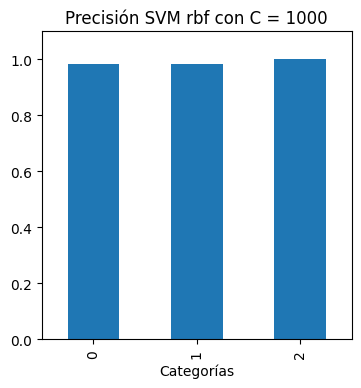

La precisión del clasificador SVM rbf con C = 1000 es: 0.989


array([0, 2, 1, ..., 1, 0, 0])

In [ ]:
imagen_2 = cv2.imread('/content/drive/MyDrive/Grupo 3 ML/TP3/Ejercicio 2/Otras vacas/2.jpg',1) #con 1 la leemos a color
imagen_RGB_2 = cv2.cvtColor(imagen_2, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(imagen_RGB_2)
plt.show()

resultadosImg(imagen_RGB_2, x_train, y_train, x_test, y_test, c=1000, tipo="rbf")

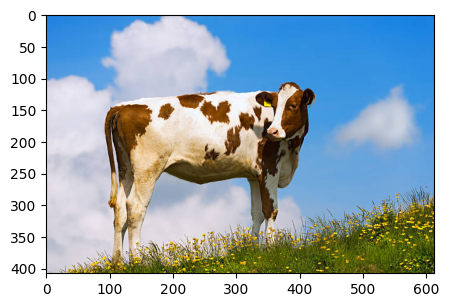

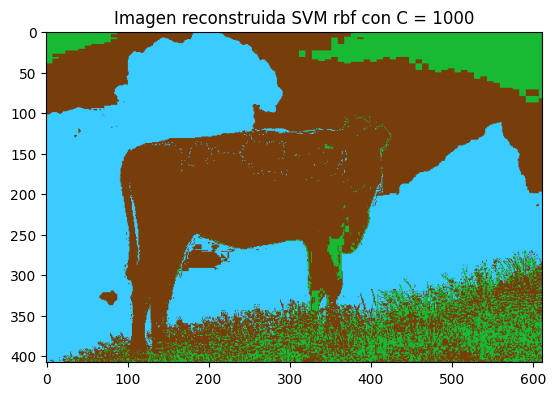

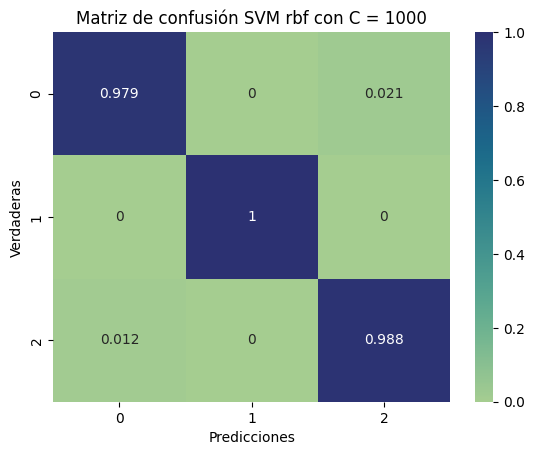

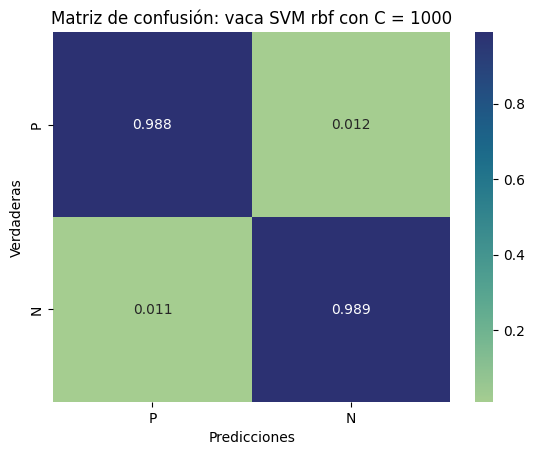

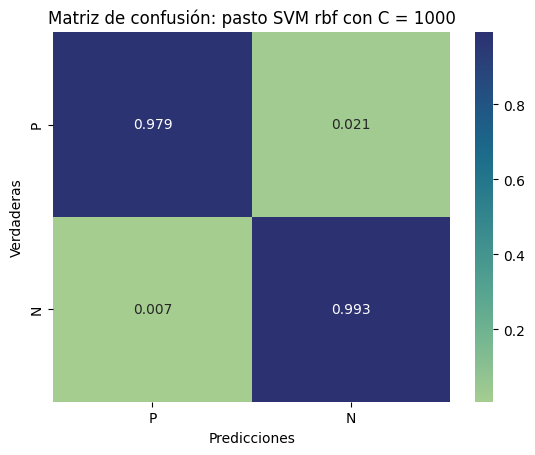

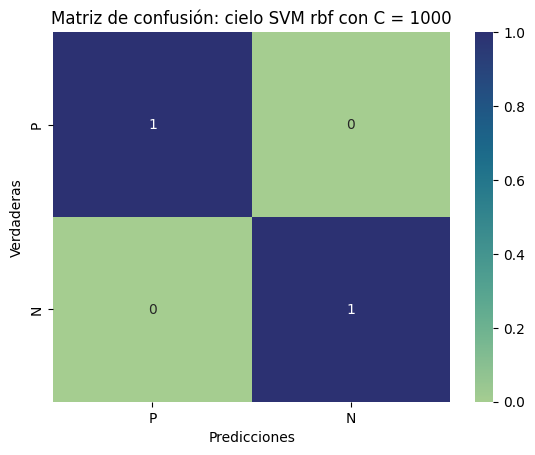

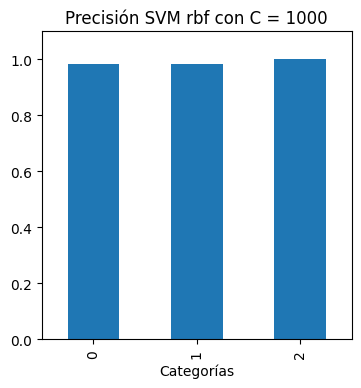

La precisión del clasificador SVM rbf con C = 1000 es: 0.989


array([0, 2, 1, ..., 1, 0, 0])

In [ ]:
imagen_3 = cv2.imread('/content/drive/MyDrive/Grupo 3 ML/TP3/Ejercicio 2/Otras vacas/3.jpg',1) #con 1 la leemos a color
imagen_RGB_3 = cv2.cvtColor(imagen_3, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(imagen_RGB_3)
plt.show()

resultadosImg(imagen_RGB_3, x_train, y_train, x_test, y_test, c=1000, tipo="rbf")

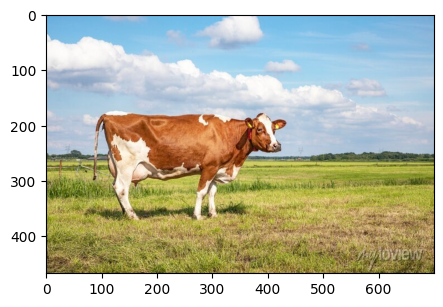

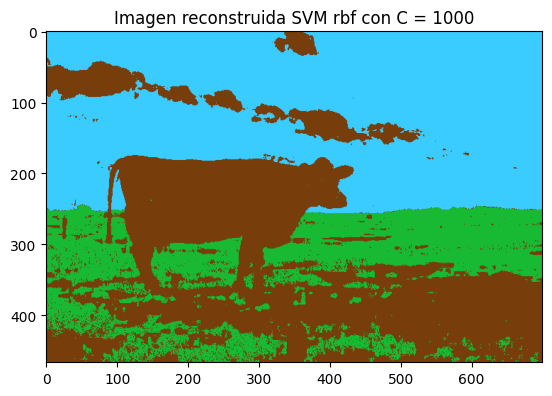

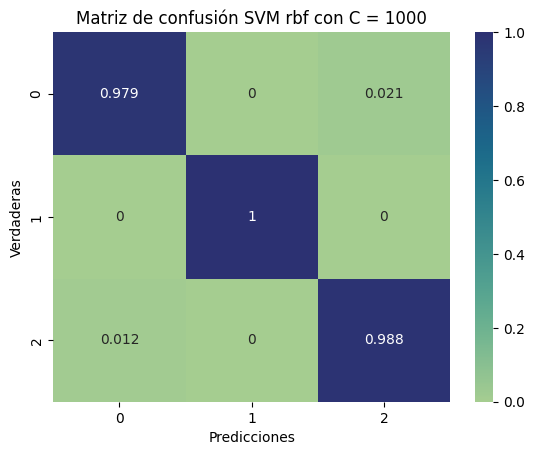

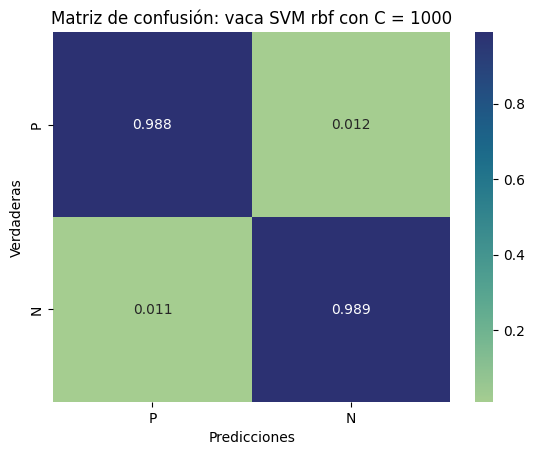

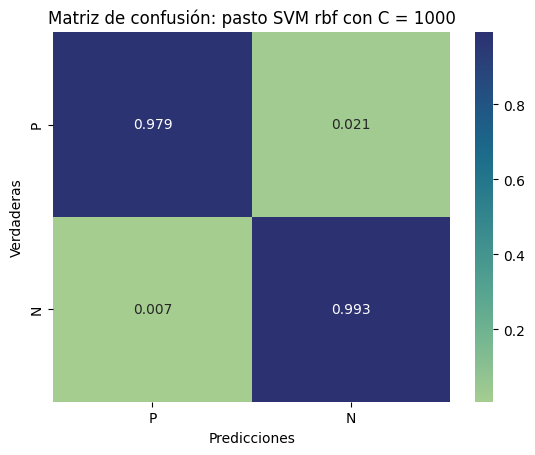

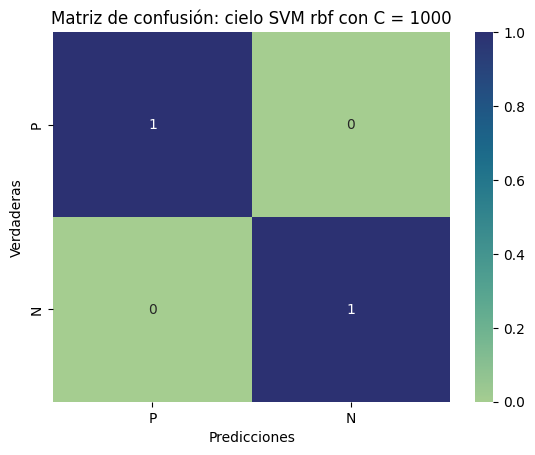

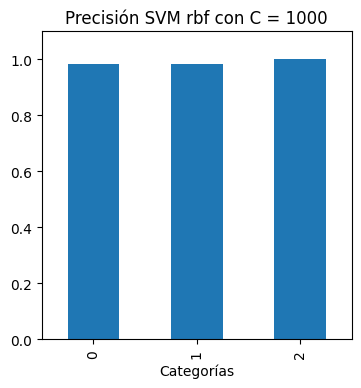

La precisión del clasificador SVM rbf con C = 1000 es: 0.989


In [ ]:
imagen_4 = cv2.imread('/content/drive/MyDrive/BIO/5to año/ML/Grupo 3 ML/TP3/Ejercicio 2/Otras vacas/4.jpg',1) #con 1 la leemos a color
imagen_RGB_4 = cv2.cvtColor(imagen_4, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(imagen_RGB_4)
plt.show()

resultadosImg(imagen_RGB_4, x_train, y_train, x_test, y_test, c=1000, tipo="rbf")

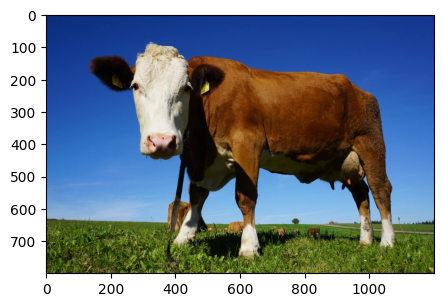

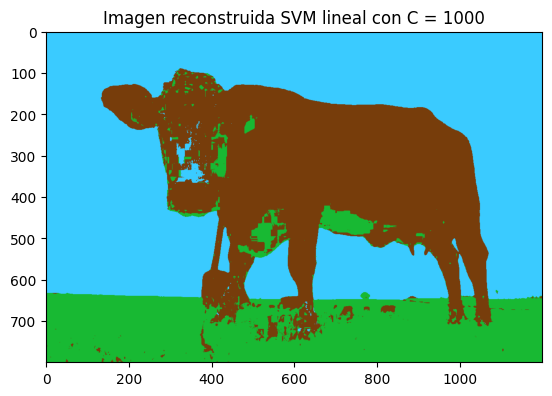

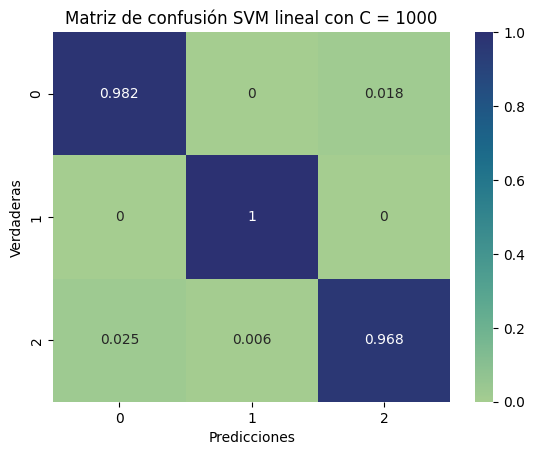

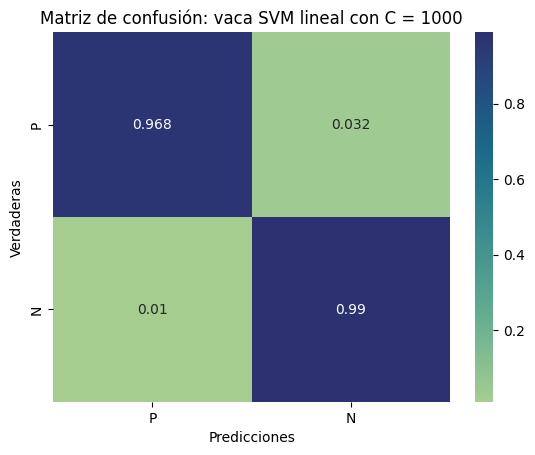

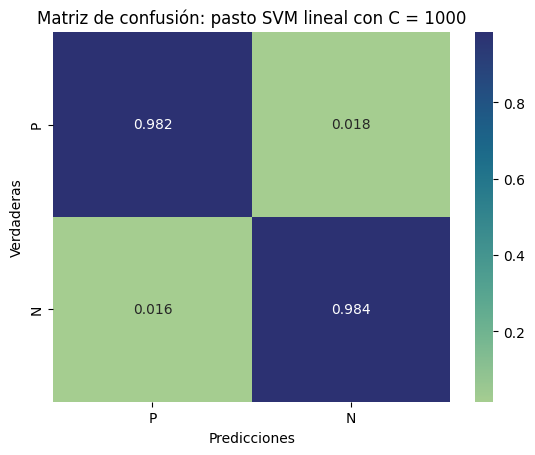

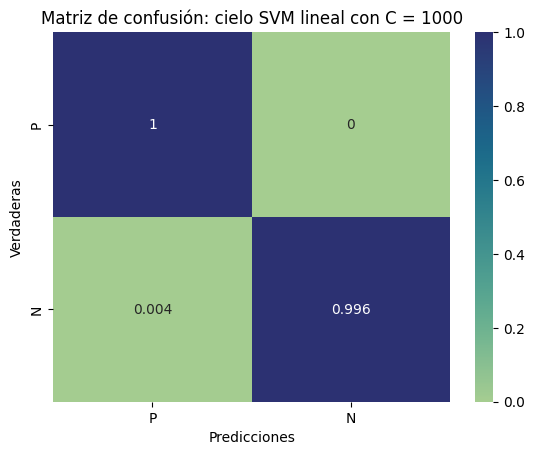

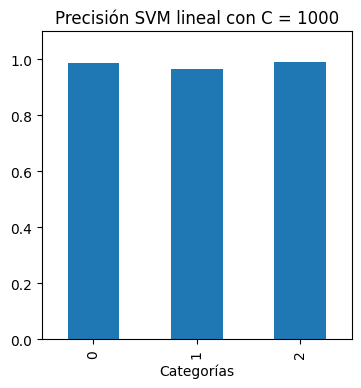

La precisión del clasificador SVM lineal con C = 1000 es: 0.981


In [ ]:
imagen_5 = cv2.imread('/content/drive/MyDrive/Grupo 3 ML/TP3/Ejercicio 2/Otras vacas/5.jpg',1) #con 1 la leemos a color
imagen_RGB_5 = cv2.cvtColor(imagen_5, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(imagen_RGB_5)
plt.show()

resultadosImg(imagen_RGB_5, x_train, y_train, x_test, y_test, c=1000, tipo="rbf")

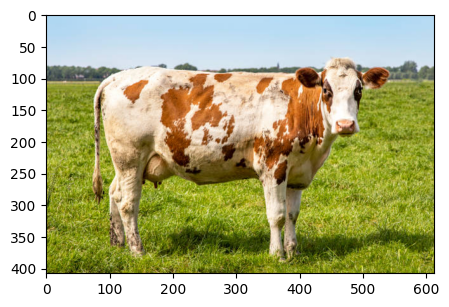

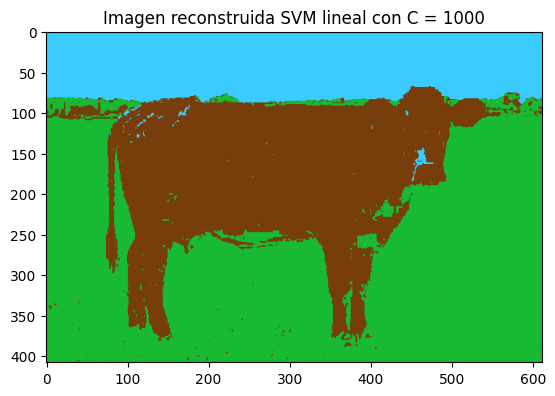

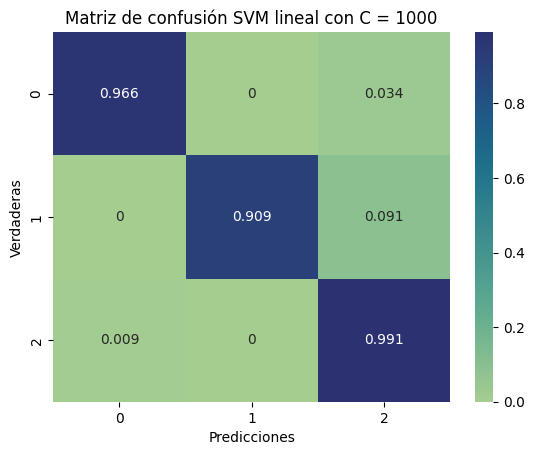

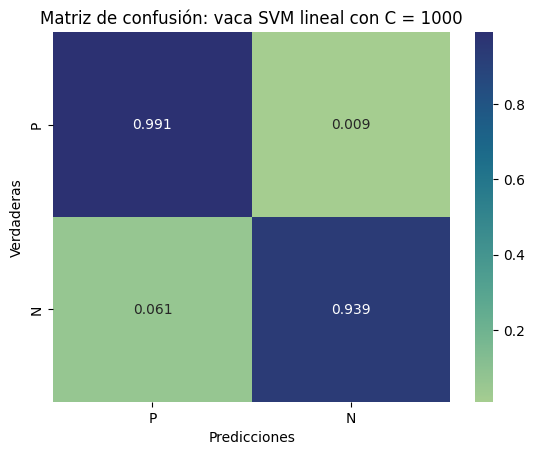

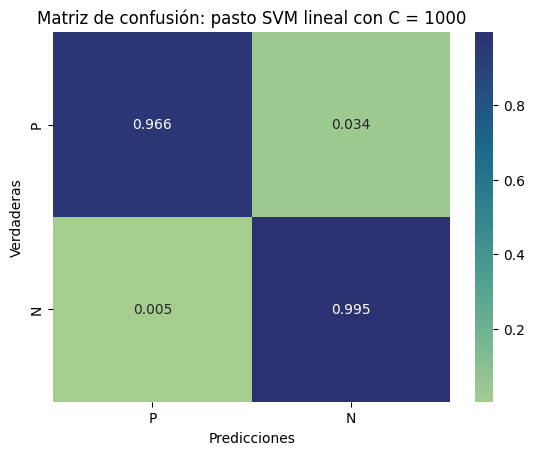

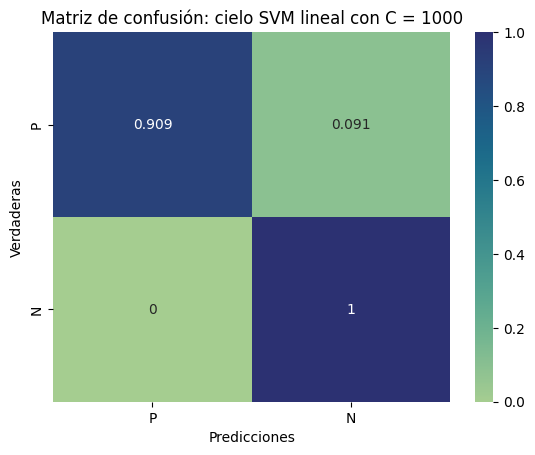

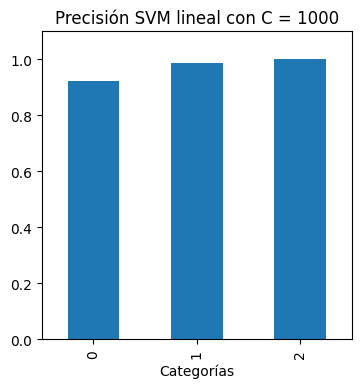

La precisión del clasificador SVM lineal con C = 1000 es: 0.961


In [ ]:
imagen_6 = cv2.imread('/content/drive/MyDrive/Grupo 3 ML/TP3/Ejercicio 2/Otras vacas/6.jpg',1) #con 1 la leemos a color
imagen_RGB_6 = cv2.cvtColor(imagen_6, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(imagen_RGB_6)
plt.show()

resultadosImg(imagen_RGB_6, x_train, y_train, x_test, y_test, c=1000, tipo="rbf")

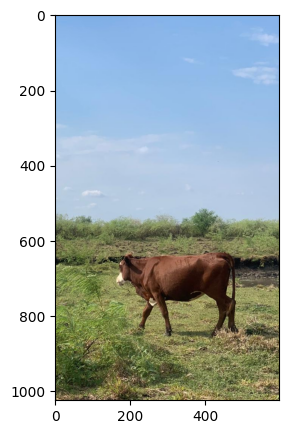

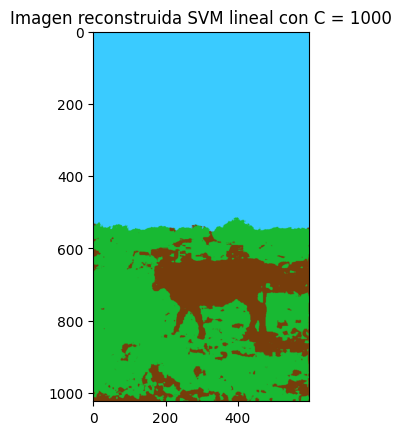

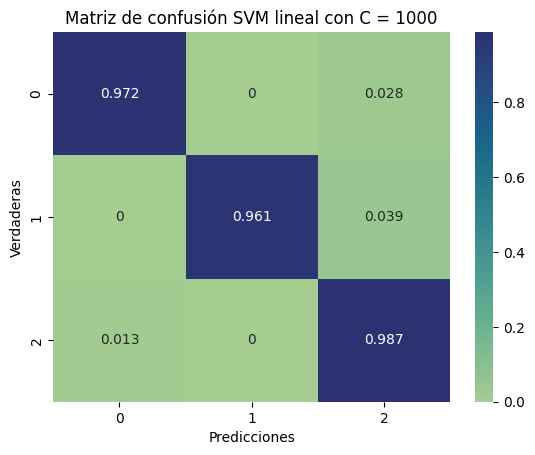

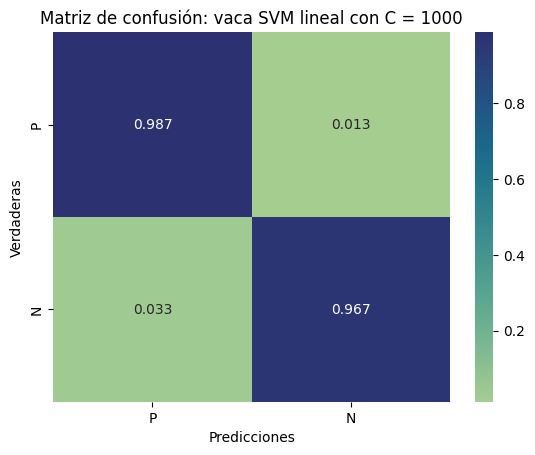

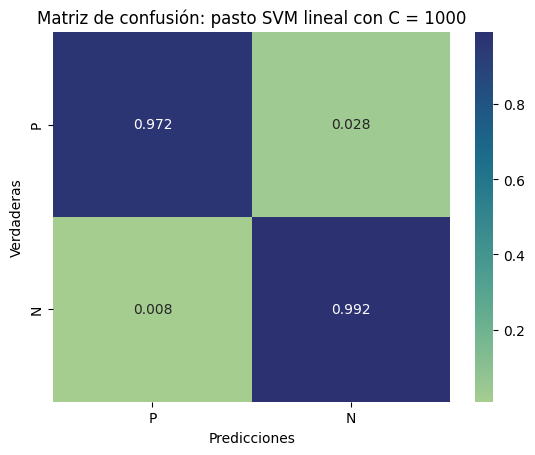

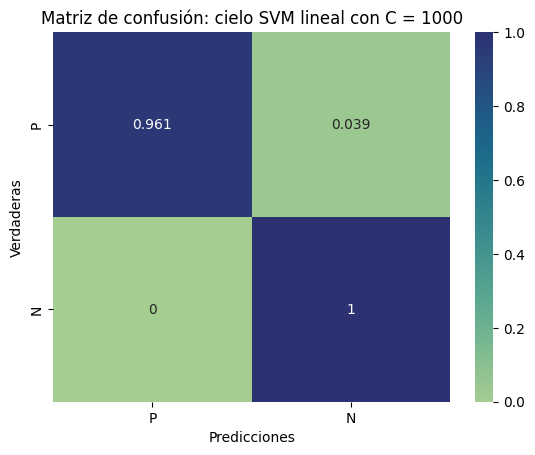

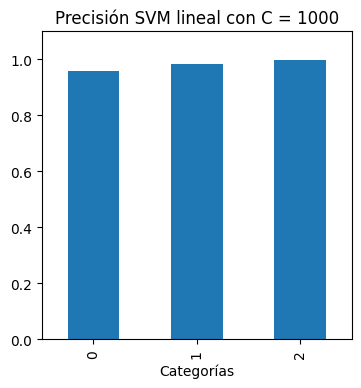

La precisión del clasificador SVM lineal con C = 1000 es: 0.975


In [ ]:
imagen_7 = cv2.imread('/content/drive/MyDrive/Grupo 3 ML/TP3/Ejercicio 2/Otras vacas/7.jpeg',1) #con 1 la leemos a color
imagen_RGB_7 = cv2.cvtColor(imagen_7, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(imagen_RGB_7)
plt.show()

resultadosImg(imagen_RGB_7, x_train, y_train, x_test, y_test, c=1000, tipo="rbf")

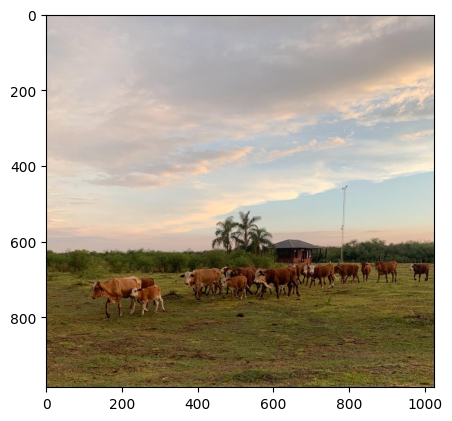

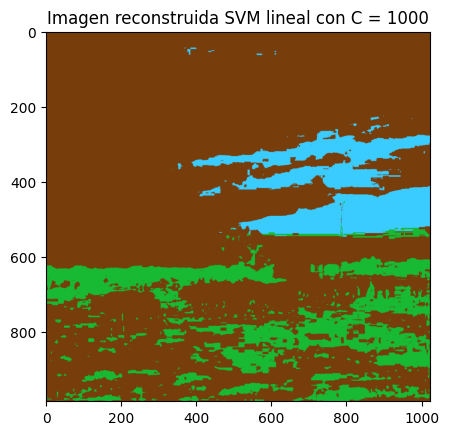

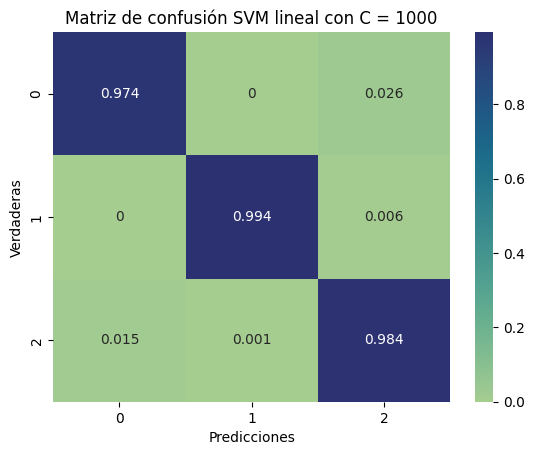

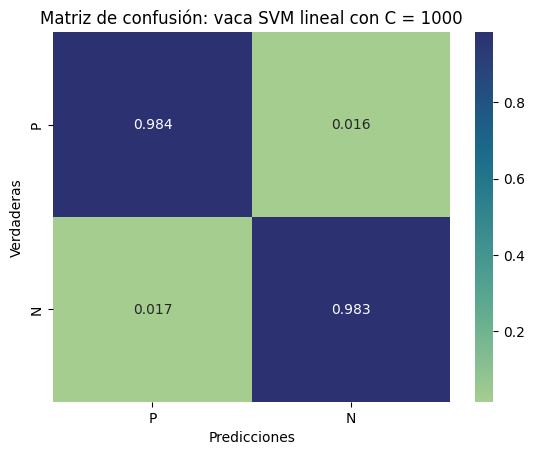

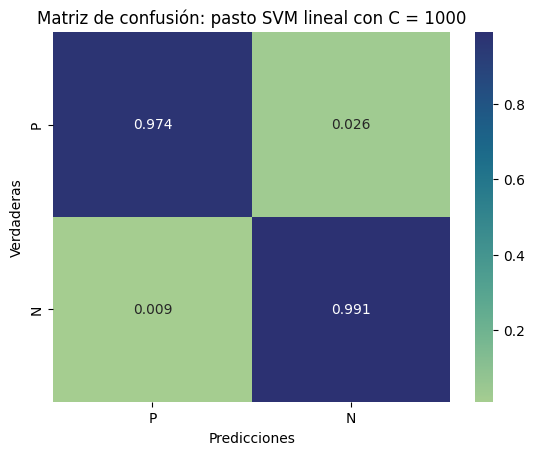

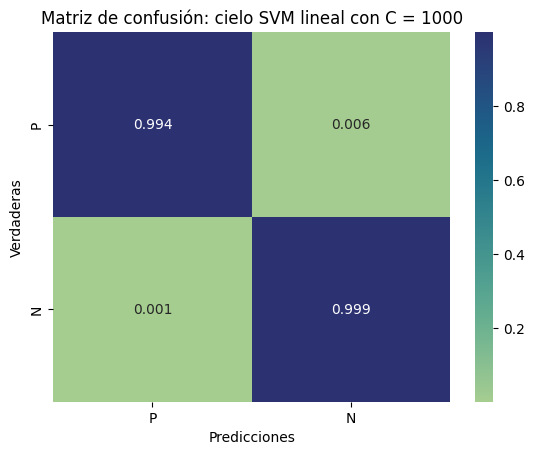

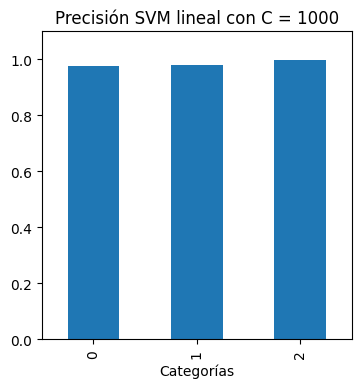

La precisión del clasificador SVM lineal con C = 1000 es: 0.983


In [ ]:
imagen_8 = cv2.imread('/content/drive/MyDrive/Grupo 3 ML/TP3/Ejercicio 2/Otras vacas/8.jpeg',1) #con 1 la leemos a color
imagen_RGB_8 = cv2.cvtColor(imagen_8, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5,5))
plt.imshow(imagen_RGB_8)
plt.show()

resultadosImg(imagen_RGB_8, x_train, y_train, x_test, y_test, c=1000, tipo="rbf")

En las primeras seis se puede ver que en general clasificó muy bien al cielo, excepto en una de ellas la cual tenía colores claritos. En general hay una mayor confusión en la clasificación de la vaca respecto al pasto y al cielo.

Las últimas dos son fotos que habíamos sacado nosotras y podemos ver que hay una peor clasificación. Esto se debe a que hay tonalidades marrones en el pasto.

El clasificador que dio mejores resultados fue el lineal, consideramos que esto se debe a que en las nuevas hay un mayor contraste entre los colores de las vacas respecto al pasto y cielo. Esta característica implicaría que los datos son más fáciles de separar.


# Resumen de resultados

* A mayor C:

  * SVM Radial→ Mayor precisión.

  * SVM Lineal→ Menor precisión. 

* Matrices de confusión de modelos:
  * A mayor C→ mejora la clasificación (poco)

* Mejor clasificador s/precisión : SVM radial con C = 1000.

* El clasificador SVM Lineal C=1000 clasificó mejor los píxeles.

* Matrices de confusión por categoría:
  * Vaca (0): mejora cuando aumenta C 
  * Pasto (1):
    * Lineal: bajo C → mejor clasificación
  * Cielo (2):
    * Lineal: bajo C → peor clasificación
    * Polinómico y el radial no depende de C y clasifica bien

* Precisión por categoría: no varió.

* A mayor C→ no variaron los resultados del polinómico→ Posiblemente variando el parámetro degree se pueden ver cambios. Nosotras empleamos el valor de default de la función el cual es 3.

